# Лабораторная работа №3 
## Проведение исследований с решающим деревом 

### 1. Выбор начальных условий

#### a. Набор данных для задачи классификации

Diabetes prediction dataset - https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

Набор данных для прогнозирования диабета представляет собой набор медицинских и демографических данных пациентов, включая информацию об их статусе диабета (положительный или отрицательный). Эти данные включают такие характеристики, как возраст, пол, индекс массы тела (ИМТ), гипертония, заболевания сердца, анамнез курения, уровень HbA1c и уровень глюкозы в крови. Этот набор данных может быть использован для построения моделей машинного обучения для прогнозирования диабета у пациентов на основе их истории болезни и демографической информации. Это может быть полезно медицинским работникам для выявления пациентов с потенциальным риском развития диабета и разработки индивидуальных планов лечения. Кроме того, этот набор данных может быть использован исследователями для изучения взаимосвязи между различными медицинскими и демографическими факторами и вероятностью развития диабета.

#### b. Набор данных для задачи регрессии

Honey purity dataset - https://www.kaggle.com/datasets/stealthtechnologies/predict-purity-and-price-of-honey

Набор данных для прогнозирования качества и цены мёда. Решение данной задачи будет полезно пчеловодам для контроля качества их продукции и обоснования ее цены.


#### c. Выбор метрик качества

##### Задача классификации:

1) $Fbeta-score$ - основная метрика. Т.к. классы несбалансированы (здоровых людей больше чем, больных диабетом), то accuracy может быть обманчивой. $Fbeta-score$ учитывает $precision$ и $recall$, что подходит для медицинской диагностики, где важно найти найти как можно больше больных (высокий $recall$), но при этом не напугать здоровых (высокий $precision$). Дает больший вес $recall$ метрике при возрастании $beta$. $beta = 1,2,3, ...$

2) $Recall$ - показывает сколько из всех рельно больных мы нашли.

3) $Precision$ - показывает сколько из всех предсказанных больных действительно больны.

4) $Accuracy$ - дополнительная метрика для общего понимания доли верных ответов.

##### Задача регрессии:

1) $MAE$ - показывает среднюю абсолютную ошибку в условных ед. Легко интерпретируется (В среднем модель ошибается на N у.е.).

2) $RMSE$ - более строгая метрика, которая сильнее штрафует за большие ошибки предсказания.

3) $R^2$ - показывает насколько модель предсказывает лучше, чем среднее значение.

### 2. Создание бейзлайна и оценка качества

#### 2.1. Обучение моделей из sklearn для решения задачи классификации и оценка качества по выбранным метрикам.

0. Подключим необходимые модули

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer

1. Загрузим датасет и посмотрим, что он из себя представляет

In [2]:
diabetes_df = pd.read_csv("datasets/diabetes_prediction_dataset.csv")

def proportional_stratified_sample(df, stratify_col, fraction=0.1, random_state=42):
    return df.groupby(stratify_col, group_keys=False).apply(
        lambda x: x.sample(frac=fraction, random_state=random_state)
    )

diabetes_df = proportional_stratified_sample(diabetes_df, 'diabetes', fraction=0.2, random_state=42)

diabetes_df.head()

/tmp/ipykernel_29774/1395300462.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(stratify_col, group_keys=False).apply(


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
21737,Female,35.0,0,0,No Info,27.32,3.5,200,0
62807,Male,66.0,0,0,No Info,27.32,4.5,145,0
38693,Male,32.0,0,0,never,32.71,6.6,90,0
72875,Male,46.0,0,0,No Info,32.78,4.0,80,0
14817,Female,22.0,0,0,never,23.51,4.5,158,0


Посмотрим информацию о датасете

In [3]:
print(diabetes_df.info())
diabetes_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 21737 to 23436
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               20000 non-null  object 
 1   age                  20000 non-null  float64
 2   hypertension         20000 non-null  int64  
 3   heart_disease        20000 non-null  int64  
 4   smoking_history      20000 non-null  object 
 5   bmi                  20000 non-null  float64
 6   HbA1c_level          20000 non-null  float64
 7   blood_glucose_level  20000 non-null  int64  
 8   diabetes             20000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 1.5+ MB
None


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000
mean,42.060048,0.072650,0.039550,27.334329,5.526775,138.06250,0.085000
std,22.534019,0.259568,0.194904,6.618437,1.074582,40.60898,0.278889
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.00000,0.000000
25%,24.000000,0.000000,0.000000,23.770000,4.800000,100.00000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.00000,0.000000
75%,60.000000,0.000000,0.000000,29.500000,6.200000,159.00000,0.000000
max,80.000000,1.000000,1.000000,88.760000,9.000000,300.00000,1.000000


Посмотрим сколько у нас null столбцев

In [4]:
diabetes_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Посмотрим сколько у нас повторяющихся строк

In [5]:
diabetes_df.duplicated().sum()

np.int64(197)

Посмотрим информацию о категориальных данных

In [6]:
print(diabetes_df['gender'].value_counts())
print(diabetes_df['smoking_history'].value_counts())

gender
Female    11735
Male       8262
Other         3
Name: count, dtype: int64
smoking_history
No Info        7241
never          6955
former         1904
current        1826
not current    1283
ever            791
Name: count, dtype: int64


2. Сделаем минимально необходимую обработку и обучим модели: 

In [7]:
gender_dummies = pd.get_dummies(diabetes_df['gender'], drop_first=True)
smoking_history_dummies = pd.get_dummies(diabetes_df['smoking_history'], drop_first=True)
onehot_diabetes_df = pd.concat([diabetes_df, gender_dummies, smoking_history_dummies], axis=1)

onehot_diabetes_df.drop(['gender', 'smoking_history'], axis=1, inplace=True)

Разделим датафрейм на features и target, а также train и test

In [8]:
diabetes_X = onehot_diabetes_df.drop('diabetes', axis=1)
diabetes_y = onehot_diabetes_df['diabetes']
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes_X,
    diabetes_y,
    test_size=0.2,
    stratify=diabetes_y,
    random_state=42
)

Кросс-валидация и выбор лучшей модели по fbeta-score (beta = 1,2,3)

In [9]:
from sklearn.base import clone
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()


def find_optimal_threshhold_cv(model, X, y, cv=5, f_beta=1, eps=1e-9, report=False):
    skf = StratifiedKFold(n_splits=cv)
    fold_scores = []
    models = []
    thresholds = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        fold_model = clone(model)
        fold_model.fit(X_train, y_train)
        models.append(fold_model)
        
        y_prob_val = fold_model.predict_proba(X_val)[:, 1]
        prec, rec, thresh = precision_recall_curve(y_val, y_prob_val)
        f_beta_scores = (1 + f_beta ** 2) * (prec * rec) / ((f_beta ** 2 * prec) + rec + eps)
        optimal_thresh_fold = thresh[f_beta_scores.argmax()]
        thresholds.append(optimal_thresh_fold)
        
        y_pred_val = (y_prob_val >= optimal_thresh_fold).astype(int)
        fold_scores.append({
            'classification_report': classification_report(y_val, y_pred_val),
            'f1_score': fbeta_score(y_val, y_pred_val, beta=1),
            'f2_score': fbeta_score(y_val, y_pred_val, beta=2),
            'f3_score': fbeta_score(y_val, y_pred_val, beta=3),
            'f_beta_score': fbeta_score(y_val, y_pred_val, beta=f_beta)
        })
    
    best_fold_idx = np.argmax([f['f_beta_score'] for f in fold_scores])
    best_model = models[best_fold_idx]
    best_threshold = thresholds[best_fold_idx]
    best_fold_score = fold_scores[best_fold_idx]
    
    if report:        
        print(f"\n=== Best Model f{f_beta} on validation ===")
        print(f"Best fold: {best_fold_idx + 1}")
        print(best_fold_score['classification_report'])
        print(f"Best f1-score: {best_fold_score['f1_score']:.4f}")
        print(f"Best f2-score: {best_fold_score['f2_score']:.4f}")
        print(f"Best f3-score: {best_fold_score['f3_score']:.4f}")
        print(f"Best f{f_beta}-score: {best_fold_score['f_beta_score']:.4f}")
        print(f"Best threshold: {best_threshold}")
    
    return best_model, best_threshold, best_fold_score
    

optimal_models = {}      
optimal_thresholds = {}
optimal_fold_scores = {}

for f_score in [1, 2, 3]:
    optimal_models[f'f{f_score}'], optimal_thresholds[f'f{f_score}'], optimal_fold_scores[f'f{f_score}'] = find_optimal_threshhold_cv(
        model,
        diabetes_X_train,
        diabetes_y_train,
        cv=5,
        f_beta=f_score,
        report=True
    )
    


=== Best Model f1 on validation ===
Best fold: 4
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2928
           1       0.73      0.75      0.74       272

    accuracy                           0.95      3200
   macro avg       0.85      0.86      0.86      3200
weighted avg       0.96      0.95      0.96      3200

Best f1-score: 0.7391
Best f2-score: 0.7456
Best f3-score: 0.7478
Best f1-score: 0.7391
Best threshold: 1.0

=== Best Model f2 on validation ===
Best fold: 4
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2928
           1       0.71      0.75      0.73       272

    accuracy                           0.95      3200
   macro avg       0.84      0.86      0.85      3200
weighted avg       0.95      0.95      0.95      3200

Best f1-score: 0.7308
Best f2-score: 0.7444
Best f3-score: 0.7490
Best f2-score: 0.7444
Best threshold: 1.0

=== Best Model f3 on validati

Проведем замеры на тестовой выборке

In [10]:
for f_score in [1, 2, 3]:
    model = optimal_models[f'f{f_score}']
    threshold = optimal_thresholds[f'f{f_score}']
    
    y_prob_test = model.predict_proba(diabetes_X_test)[:, 1]
    y_pred_test = (y_prob_test >= threshold).astype(int)
    
    print(f"\n=== Test Model f{f_score} ===")
    print(classification_report(diabetes_y_test, y_pred_test))
    print(f"f1-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=1):.4f}")
    print(f"f2-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=2):.4f}")
    print(f"f3-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=3):.4f}")
    print(f"f{f_score}-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=f_score):.4f}")    


=== Test Model f1 ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3660
           1       0.69      0.76      0.72       340

    accuracy                           0.95      4000
   macro avg       0.83      0.86      0.85      4000
weighted avg       0.95      0.95      0.95      4000

f1-score: 0.7237
f2-score: 0.7444
f3-score: 0.7515
f1-score: 0.7237

=== Test Model f2 ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3660
           1       0.70      0.76      0.73       340

    accuracy                           0.95      4000
   macro avg       0.84      0.87      0.85      4000
weighted avg       0.95      0.95      0.95      4000

f1-score: 0.7293
f2-score: 0.7501
f3-score: 0.7574
f2-score: 0.7501

=== Test Model f3 ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3660
           1       0.69      0.7

| Модель | Класс | Precision | Recall | F1-Score | Support | F-метрики |
|--------|-------|-----------|--------|----------|---------|----------------------|
| **Test Model f1** | **0** | 0.98 | 0.97 | 0.97 | 3660 |  |
| **(threshold: 1.0)** | **1** | 0.69 | 0.76 | 0.72 | 340 | |
| |       |      |      |      |     |                      |
| | **Macro Avg** | 0.83 | 0.86 | 0.85 | 4000 | **F1-score: 0.7237** |
| | **Weighted Avg** | 0.95 | 0.95 | 0.95 | 4000 | **F2-score: 0.7444** |
| | **Accuracy** | — | — | 0.95 | 4000 | **F3-score: 0.7515** | 
| |       |      |      |      |     |   |
| |       |      |      |      |     |  |
| **Test Model f2** | **0** | 0.98 | 0.97 | 0.97 | 3660 |  |
| **(threshold: 1.0)** | **1** | 0.70 | 0.76 | 0.73 | 340 |  |
| |       |      |      |      |     |                      |
| | **Macro Avg** | 0.84 | 0.87 | 0.85 | 4000 | **F1-score: 0.7293** |
| | **Weighted Avg** | 0.95 | 0.95 | 0.95 | 4000 | **F2-score: 0.7501** |
| | **Accuracy** | — | — | 0.95 | 4000 | **F3-score: 0.7574** |
| |       |      |      |      |     |                      |
| |       |      |      |      |     |                      |
| **Test Model f3** | **0** | 0.98 | 0.97 | 0.97 | 3660 |  |
| **(threshold: 1.0)**| **1** | 0.69 | 0.75 | 0.72 | 340 |  |
| |       |      |      |      |     |                      |
| | **Macro Avg** | 0.83 | 0.86 | 0.85 | 4000 | **F1-score: 0.7211** |
| | **Weighted Avg** | 0.95 | 0.95 | 0.95 | 4000 | **F2-score: 0.7399** |
| | **Accuracy** | — | — | 0.95 | 4000 | **F3-score: 0.7464** |

#### Вывод: 

Базовое решающее дерево (sklearn) показало хорошие результаты для задачи классификации диабета. Модель F1-score достигла значения 0.7237 с высоким Precision (0.69) и Recall (0.76). Это демонстрирует применимость дерева для медицинских данных даже без дополнительной настройки и обработки признаков.

### 3. Улучшение бейзлайна

#### 3.1. Задача классификации

0. Подключение модулей

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

1. Проведем более детальный анализ датасета

Вспомним, что из себя представляет датасет

In [12]:
print(f"Количество строк: {diabetes_df.shape[0]}, столбцев {diabetes_df.shape[1]}")
print(diabetes_df.info(), diabetes_df.describe())
diabetes_df.head()

Количество строк: 20000, столбцев 9
<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 21737 to 23436
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               20000 non-null  object 
 1   age                  20000 non-null  float64
 2   hypertension         20000 non-null  int64  
 3   heart_disease        20000 non-null  int64  
 4   smoking_history      20000 non-null  object 
 5   bmi                  20000 non-null  float64
 6   HbA1c_level          20000 non-null  float64
 7   blood_glucose_level  20000 non-null  int64  
 8   diabetes             20000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 1.5+ MB
None                 age  hypertension  heart_disease           bmi   HbA1c_level  \
count  20000.000000  20000.000000   20000.000000  20000.000000  20000.000000   
mean      42.060048      0.072650       0.039550     27.334329      5.526775   


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
21737,Female,35.0,0,0,No Info,27.32,3.5,200,0
62807,Male,66.0,0,0,No Info,27.32,4.5,145,0
38693,Male,32.0,0,0,never,32.71,6.6,90,0
72875,Male,46.0,0,0,No Info,32.78,4.0,80,0
14817,Female,22.0,0,0,never,23.51,4.5,158,0


Посмотрим сколько значений пропущено

In [13]:
diabetes_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Какие есть уникальные категориальные значения

In [14]:
print(diabetes_df['gender'].value_counts())
print(diabetes_df['smoking_history'].value_counts())

gender
Female    11735
Male       8262
Other         3
Name: count, dtype: int64
smoking_history
No Info        7241
never          6955
former         1904
current        1826
not current    1283
ever            791
Name: count, dtype: int64


Построим графики распределения всех людей и тех у кого диабет.

Синий - нет диабета.

Красный - есть.

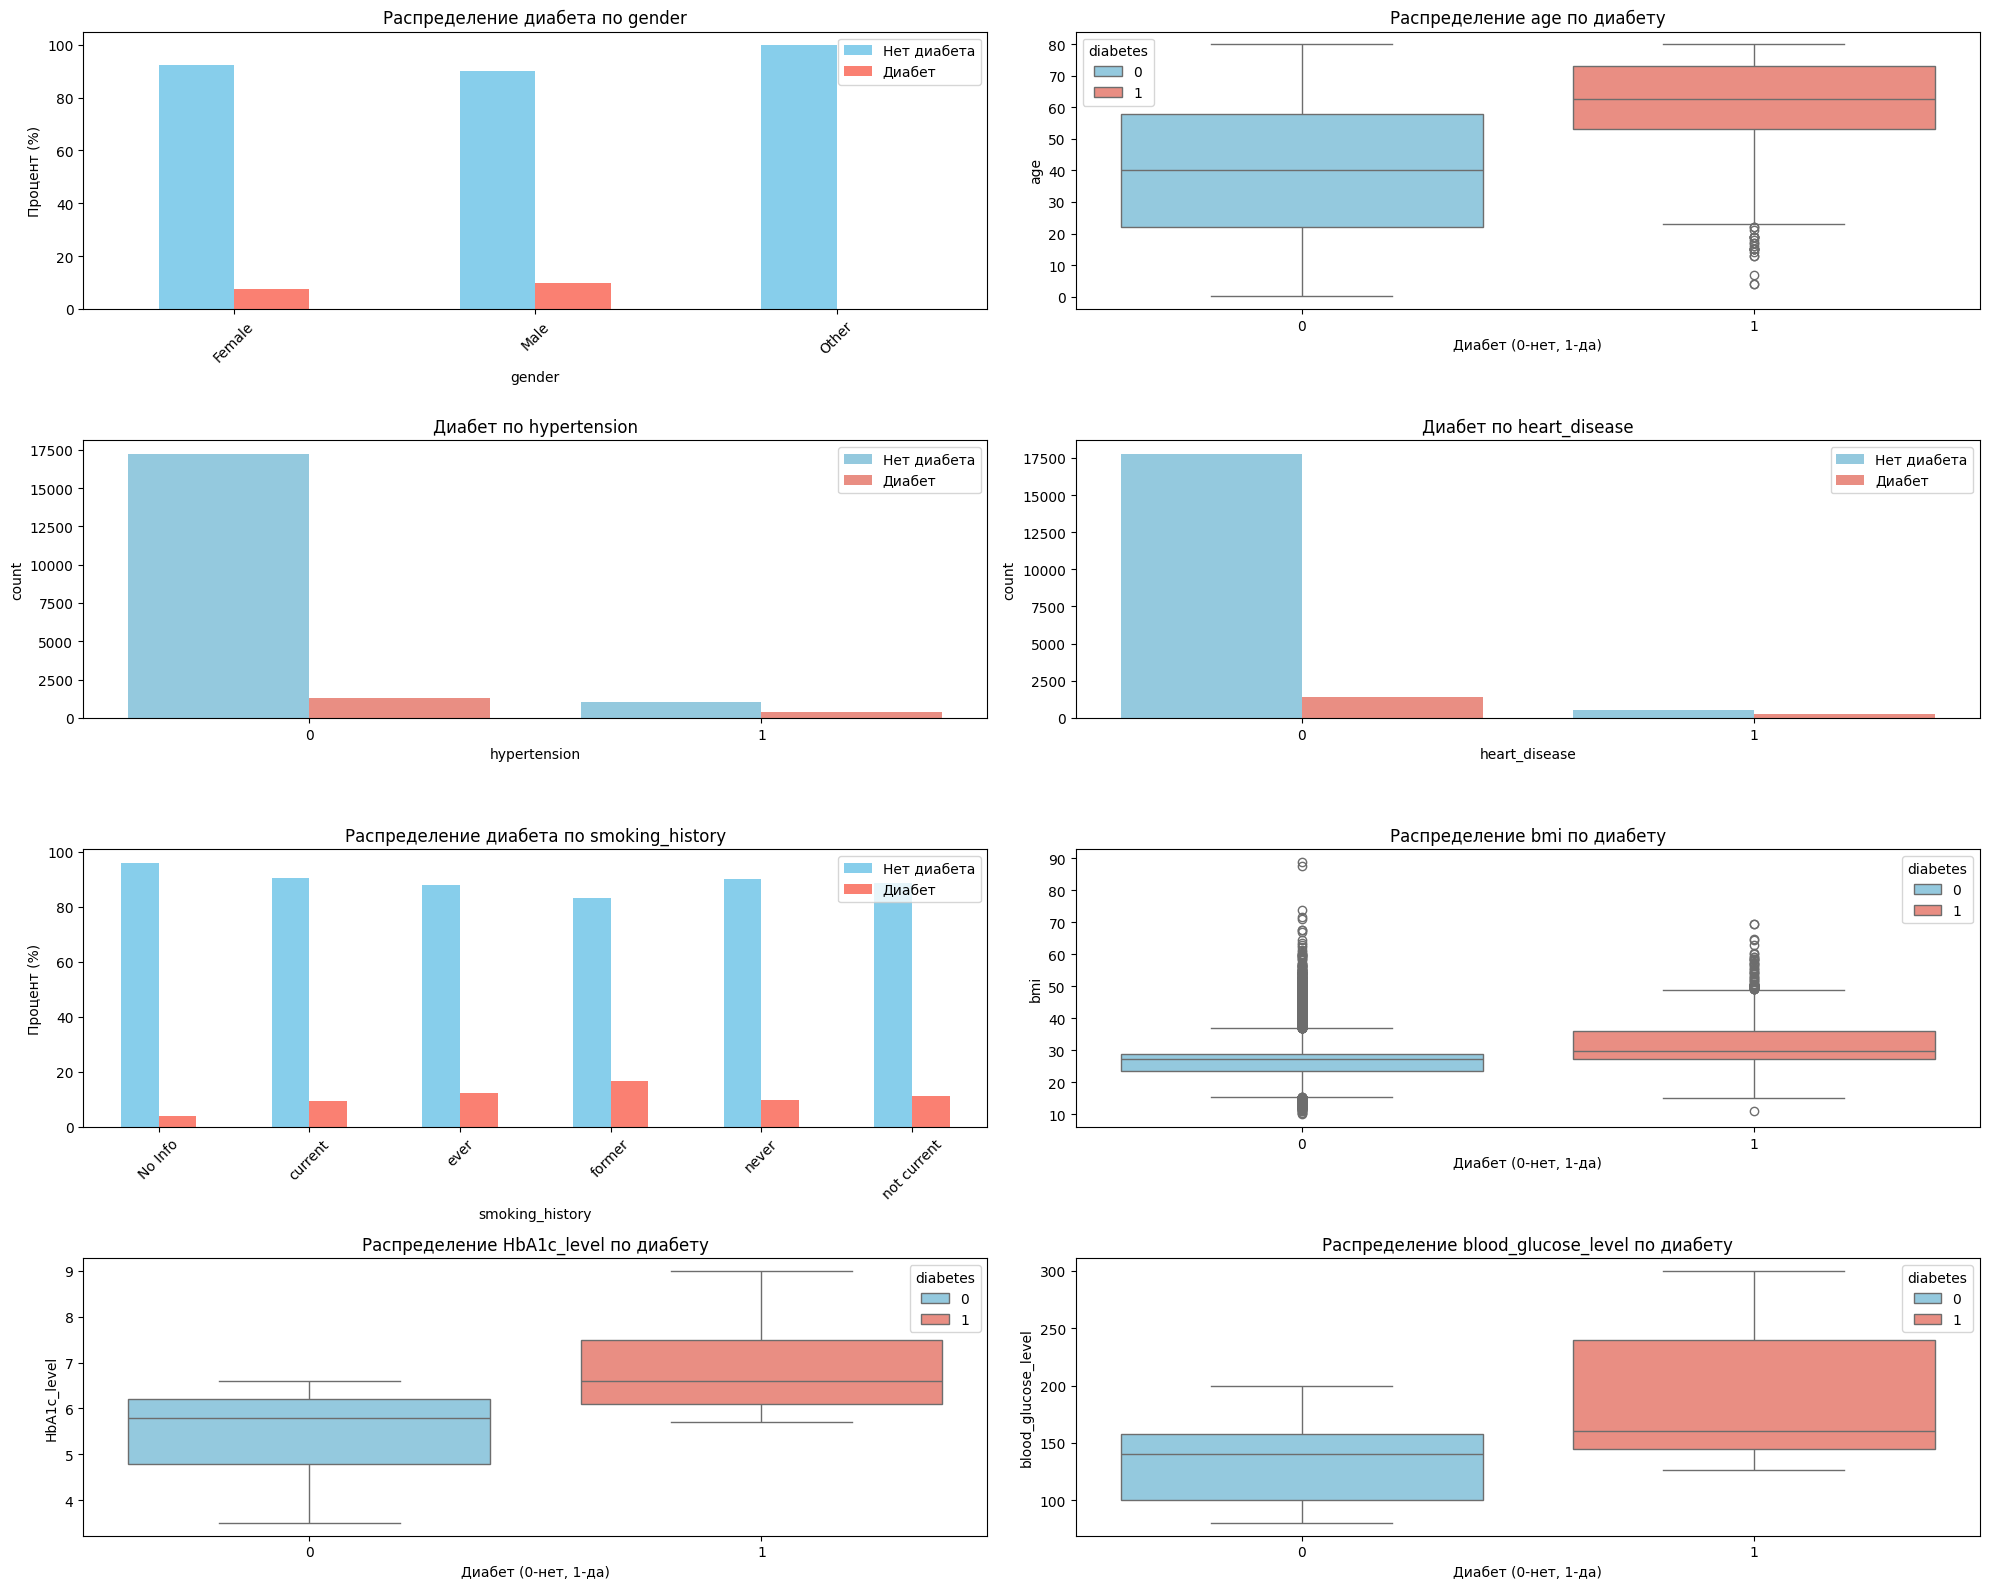

In [15]:
fig = plt.figure(figsize=(20, 16))

all_features = ['gender', 'age', 'hypertension', 'heart_disease', 
                'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']

for i, feature in enumerate(all_features, 1):
    plt.subplot(4, 2, i)
    
    if feature in ['gender', 'smoking_history']:  # Категориальные признаки
        cross_tab = pd.crosstab(diabetes_df[feature], diabetes_df['diabetes'], normalize='index') * 100
        cross_tab.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'salmon'])
        plt.title(f'Распределение диабета по {feature}')
        plt.ylabel('Процент (%)')
        plt.legend(['Нет диабета', 'Диабет'])
        plt.xticks(rotation=45)
        
    elif feature in ['hypertension', 'heart_disease']:  # Бинарные признаки
        sns.countplot(data=diabetes_df, x=feature, hue='diabetes', palette=['skyblue', 'salmon'])
        plt.title(f'Диабет по {feature}')
        plt.legend(['Нет диабета', 'Диабет'])
        
    else:  # Числовые признаки
        sns.boxplot(data=diabetes_df, x='diabetes', y=feature, palette=['skyblue', 'salmon'], hue='diabetes')
        plt.title(f'Распределение {feature} по диабету')
        plt.xlabel('Диабет (0-нет, 1-да)')

plt.tight_layout()
plt.show()

Из графика рапределения bmi явно видны выбросы. Их необходимо будет почистить

In [16]:
def remove_outliers_iqr_by_group(df, column, group_column):
    df_clean = df.copy()
    for group in df[group_column].unique():
        group_data = df[df[group_column] == group]
        Q1 = group_data[column].quantile(0.25)
        Q3 = group_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_mask = (df_clean[group_column] == group) & (
            (df_clean[column] < lower_bound) | (df_clean[column] > upper_bound)
        )
        df_clean = df_clean[~outliers_mask]
    return df_clean

diabetes_clean = remove_outliers_iqr_by_group(diabetes_df, 'bmi', 'diabetes')
diabetes_clean.shape, diabetes_df.shape

((18382, 9), (20000, 9))

Посмотрим как прошли изменения

Text(0.5, 0, 'Диабет (0-нет, 1-да)')

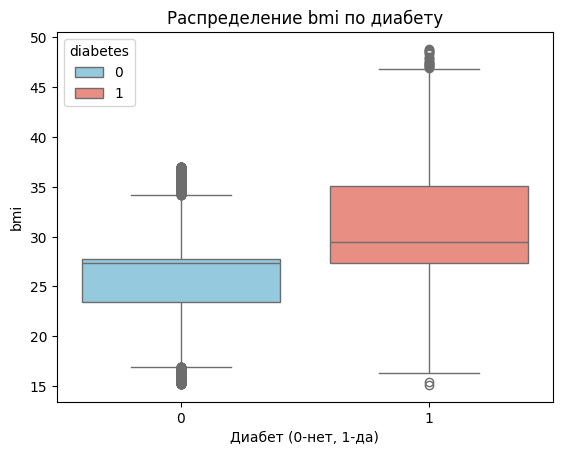

In [17]:
sns.boxplot(data=diabetes_clean, x='diabetes', y='bmi', palette=['skyblue', 'salmon'], hue='diabetes')
plt.title('Распределение bmi по диабету')
plt.xlabel('Диабет (0-нет, 1-да)')

Построим матрицу корреляции

<Figure size 1000x800 with 0 Axes>

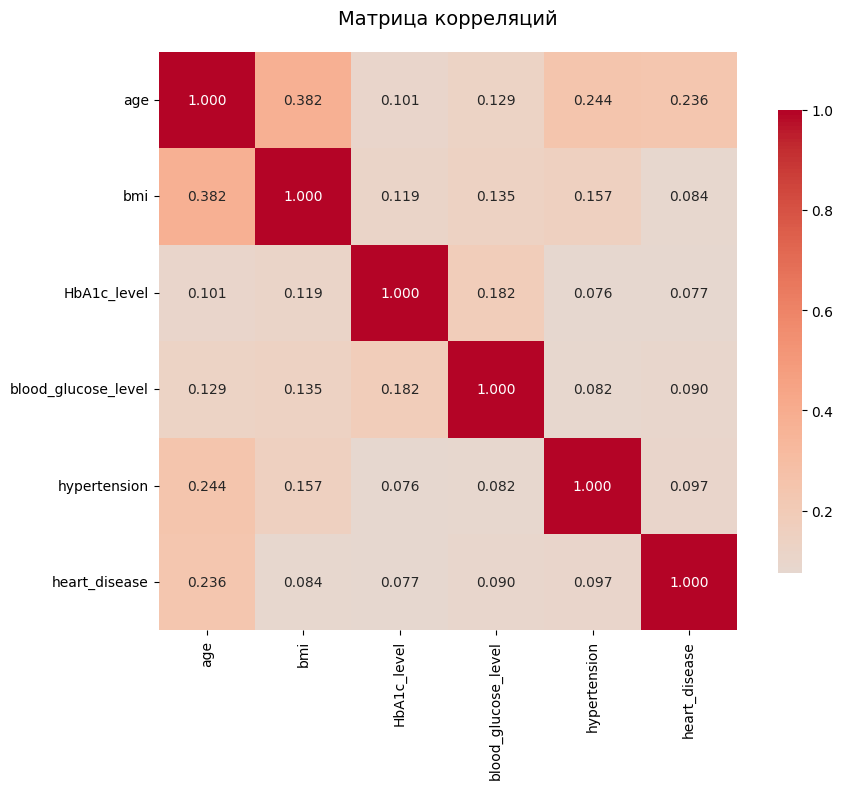

In [18]:
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
binary_features = ['hypertension', 'heart_disease']

plt.figure(figsize=(10, 8))
corr_matrix = diabetes_clean[numeric_features + binary_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title('Матрица корреляций', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Построим графику зависимости между числовыми признаками

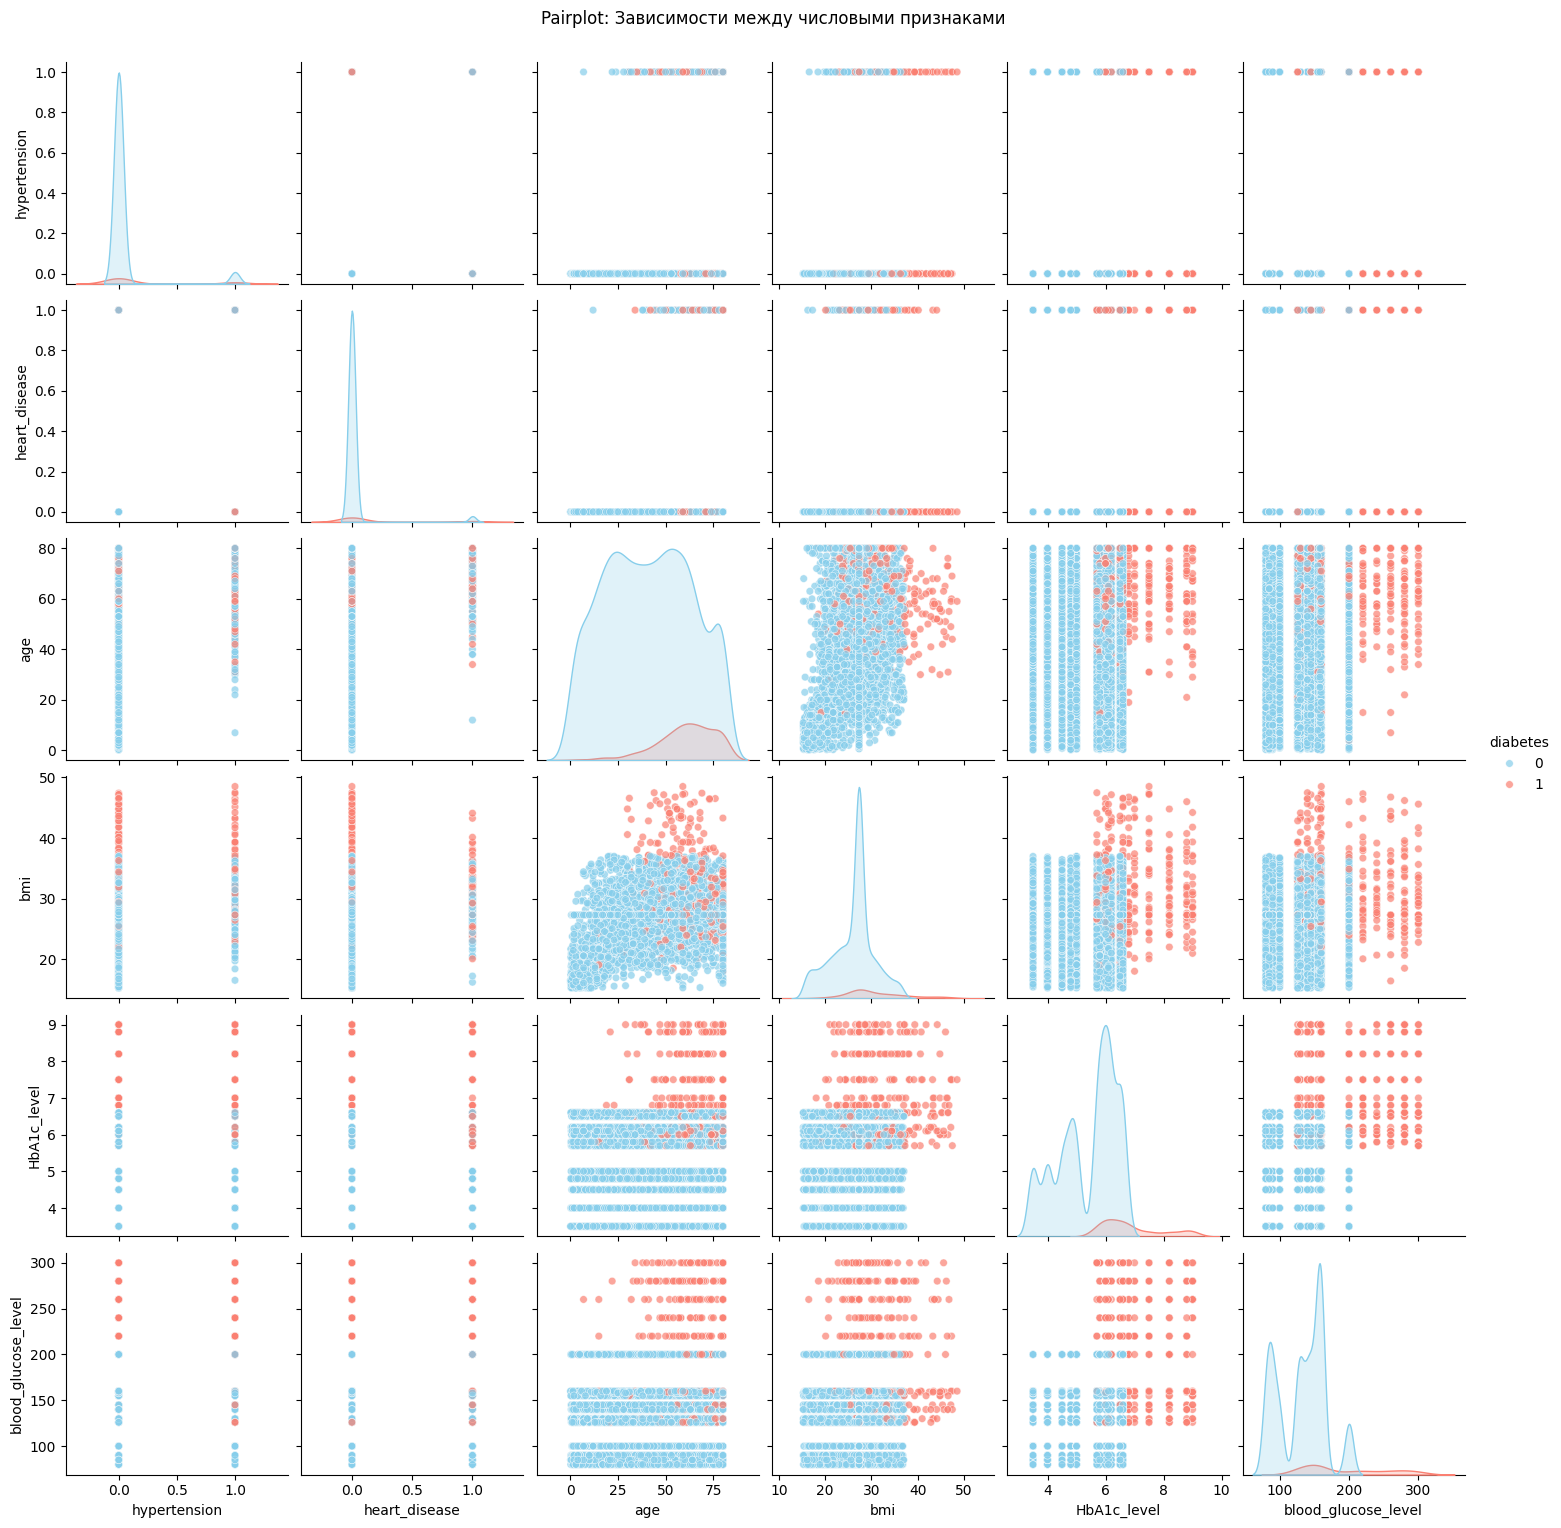

In [19]:
sns.pairplot(diabetes_clean[binary_features + numeric_features + ['diabetes']].sample(n=5000, random_state=42),
             hue='diabetes', palette=['skyblue', 'salmon'],
             diag_kind='kde', plot_kws={'alpha': 0.7, 's': 30})
plt.suptitle('Pairplot: Зависимости между числовыми признаками', y=1.02)
plt.show()

Создадим новые фичи на основе числовых

In [20]:
def create_num_features(df):
    new_df = df.copy()
    
    new_df['log(age*bmi*HbA1c_level*blood_glucose_level+1)'] = np.log(new_df['age'] * new_df['bmi'] * new_df['HbA1c_level'] * new_df['blood_glucose_level'] + 1)

    new_df['age*bmi'] = new_df['age'] * new_df['bmi']
    new_df['HbA1c_levelxblood_glucose_level'] = new_df['HbA1c_level'] * new_df['blood_glucose_level']
    new_df['bmi*blood_glucose_level'] = new_df['bmi'] * new_df['blood_glucose_level']

    new_df['bmi*HbA1c_level*blood_glucose_level'] = new_df['bmi'] * new_df['HbA1c_level'] * new_df['blood_glucose_level']

    new_df['bmi/age'] = new_df['bmi'] / (new_df['age'] + 1e-6)
    new_df['blood_glucose_level/HbA1c_level'] = new_df['blood_glucose_level'] / (new_df['HbA1c_level'] + 1e-6)
    new_df['blood_glucose_level/age'] = new_df['blood_glucose_level'] / new_df['age']


    new_df['bmi^2'] = new_df['bmi'] ** 2
    new_df['HbA1c_level^2'] = new_df['HbA1c_level'] ** 2
    new_df['blood_glucose_level^2'] = new_df['blood_glucose_level'] ** 2

    new_df['log_blood_glucose_level+1'] = np.log(new_df['blood_glucose_level'] + 1)
    new_df['log_HbA1c_level+1'] = np.log(new_df['HbA1c_level'] + 1)
    new_df['log_bmi+1'] = np.log(new_df['bmi'] + 1)

    new_df['age_z'] = (new_df['age'] - new_df['age'].mean()) / new_df['age'].std()
    new_df['bmi_z'] = (new_df['bmi'] - new_df['bmi'].mean()) / new_df['bmi'].std()
    new_df['HbA1c_level_z'] = (new_df['HbA1c_level'] - new_df['HbA1c_level'].mean()) / new_df['HbA1c_level'].std()
    new_df['blood_glucose_level_z'] = (new_df['blood_glucose_level'] - new_df['blood_glucose_level'].mean()) / new_df['blood_glucose_level'].std()

    new_df['risk_index'] = (new_df['age_z'] + new_df['bmi_z'] + new_df['HbA1c_level_z'] + new_df['blood_glucose_level_z']) / 4
    
    return new_df


Теперь поработаем с историей курения

In [21]:
print(diabetes_clean['smoking_history'].value_counts())

smoking_history
No Info        6648
never          6385
former         1737
current        1694
not current    1199
ever            719
Name: count, dtype: int64


"No Info" - Информация отсутствует (пропущенные данные)

"never" - Никогда не курил

"former" - Бывший курильщик

"current" - Текущий курильщик

"not current" - В настоящее время не курит (похоже на "former")

"ever" - Когда-либо курил (похоже на "former")


Поэтому закодирую следующим образом

In [22]:
def create_smoking_features(df):
    new_df = df.copy()
    mapping = {
        'No Info': np.nan,
        'never': 0,
        'former': 1,
        'current': 2,
        'not current': 1,
        'ever': 1
    }

    new_df['smoking_history_encoded'] = (
        new_df['smoking_history']
        .map(mapping)
        .fillna(new_df['smoking_history'].map(mapping).mean())
    )
    new_df = new_df.drop('smoking_history', axis=1)
    return new_df

Также сделаем обработку gender

In [23]:
print(diabetes_clean['gender'].value_counts())

gender
Female    10645
Male       7734
Other         3
Name: count, dtype: int64


Other заменим на среднее значение и сделаем новый признак

In [24]:
def create_gender_features(df):
    new_df = df.copy()
    mapping = {
        'Other': np.nan,
        'Male': 1,
        'Female': 0
    }

    new_df['gender_encoded'] = (
        df['gender']
        .map(mapping)
        .fillna(df['gender'].map(mapping).mean())
    )
    
    new_df = new_df.drop('gender', axis=1)
    return new_df

Добавим еще несколько бинарных признаков

In [25]:
def create_binary_features(df):
    new_df = df.copy()
    new_df['hypertension*glucose'] = new_df['hypertension'] * new_df['blood_glucose_level']
    new_df['heart_disease*HbA1c_level'] = new_df['heart_disease'] * new_df['HbA1c_level']
    new_df['overweighted'] = (new_df['bmi'] > 25).astype(int)
    new_df['obese'] = (new_df['bmi'] > 30).astype(int)
    new_df['young'] = (new_df['age'] < 30).astype(int)
    new_df['elder'] = (new_df['age'] >= 60).astype(int)
    return new_df

Медицинские показатели

In [26]:
def create_medical_features(df):
    new_df = df.copy()
    new_df['metabolic_syndrome'] = (new_df['bmi'] > 30).astype(int) + new_df['hypertension'] + new_df['heart_disease']
    new_df['heart_diseaseORhypertension'] = (new_df['heart_disease'] | new_df['hypertension']).astype(int)
    new_df['high_HbA1c_level'] = (new_df['HbA1c_level'] > 6).astype(int)
    new_df['high_blood_glucose_level'] = (new_df['blood_glucose_level'] > 125).astype(int)
    new_df['normal_blood_glucose_level'] = (new_df['blood_glucose_level'] < 100).astype(int)
    return new_df

Создать все features

In [27]:
def create_features(df):
    new_df = df.copy()
    new_df = create_num_features(new_df)
    new_df = create_smoking_features(new_df)
    new_df = create_gender_features(new_df)
    new_df = create_binary_features(new_df)
    new_df = create_medical_features(new_df)
    return new_df

diabetes_new_features = create_features(diabetes_clean)
diabetes_new_features.columns

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes',
       'log(age*bmi*HbA1c_level*blood_glucose_level+1)', 'age*bmi',
       'HbA1c_levelxblood_glucose_level', 'bmi*blood_glucose_level',
       'bmi*HbA1c_level*blood_glucose_level', 'bmi/age',
       'blood_glucose_level/HbA1c_level', 'blood_glucose_level/age', 'bmi^2',
       'HbA1c_level^2', 'blood_glucose_level^2', 'log_blood_glucose_level+1',
       'log_HbA1c_level+1', 'log_bmi+1', 'age_z', 'bmi_z', 'HbA1c_level_z',
       'blood_glucose_level_z', 'risk_index', 'smoking_history_encoded',
       'gender_encoded', 'hypertension*glucose', 'heart_disease*HbA1c_level',
       'overweighted', 'obese', 'young', 'elder', 'metabolic_syndrome',
       'heart_diseaseORhypertension', 'high_HbA1c_level',
       'high_blood_glucose_level', 'normal_blood_glucose_level'],
      dtype='object')

Построим матрицу корреляции

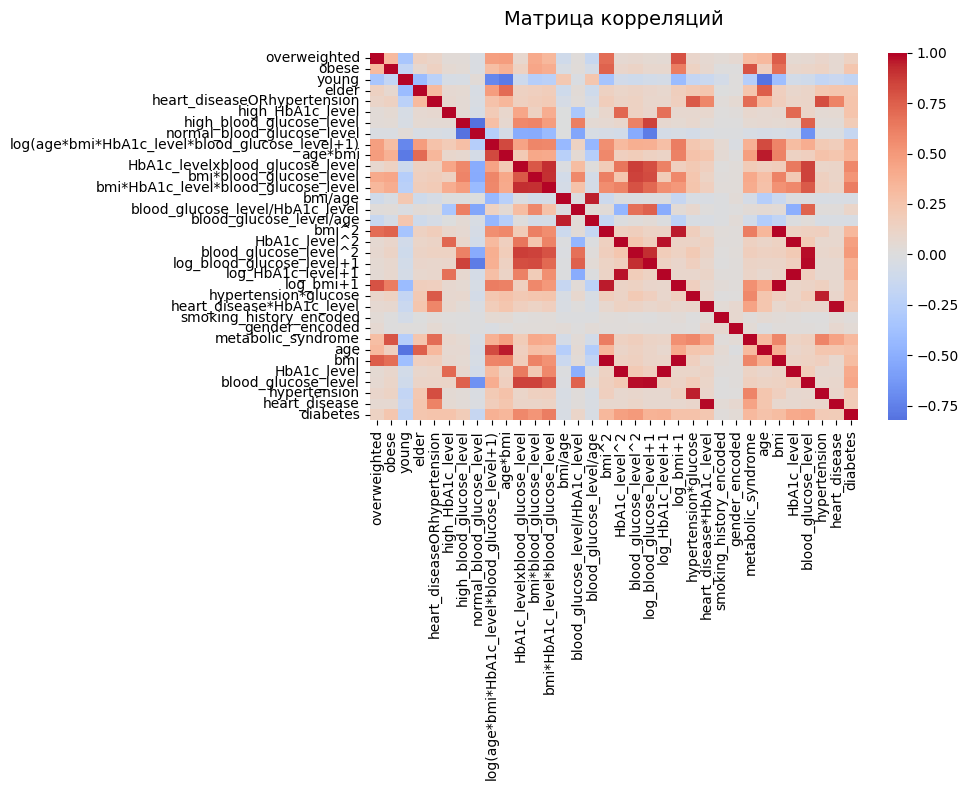

In [28]:
new_features = ['overweighted', 'obese', 'young', 'elder', 'heart_diseaseORhypertension', 'high_HbA1c_level', 'high_blood_glucose_level', 'normal_blood_glucose_level',
                'log(age*bmi*HbA1c_level*blood_glucose_level+1)', 'age*bmi', 'HbA1c_levelxblood_glucose_level', 'bmi*blood_glucose_level', 'bmi*HbA1c_level*blood_glucose_level',
                'bmi/age', 'blood_glucose_level/HbA1c_level', 'blood_glucose_level/age', 'bmi^2', 'HbA1c_level^2', 'blood_glucose_level^2', 'log_blood_glucose_level+1', 'log_HbA1c_level+1', 'log_bmi+1',
                'hypertension*glucose', 'heart_disease*HbA1c_level', 'smoking_history_encoded', 'gender_encoded', 'metabolic_syndrome']

old_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease', 'diabetes']


corr_matrix = diabetes_new_features[new_features + old_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Матрица корреляций', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Уменьшим мультиколлинеарность и упростим модель. Для этого удалю числовые признаки, которые имеют высокую корреляцию с другими. Исключу признаки с корреляцией Пирсона выше порогового значения = 0,95.

In [29]:
def drop_highly_correlated_features(df, threshold=0.95):
    df_clean = df.copy()
    corr_matrix = df_clean.corr().abs()
    upper_triangle = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    high_corr_pairs = np.where((corr_matrix > threshold) & upper_triangle)
    to_drop = set()
    for i, j in zip(*high_corr_pairs):
        feature_i = corr_matrix.columns[i]
        feature_j = corr_matrix.columns[j]
        if corr_matrix[feature_i].mean() > corr_matrix[feature_j].mean():
            to_drop.add(feature_j)
        else:
            to_drop.add(feature_i)
    df_clean = df_clean.drop(columns=to_drop)
    return df_clean

diabetes_new_features = drop_highly_correlated_features(diabetes_new_features[new_features + old_features])

Поссмотрим, что сейчас представляет из себя матрица корреляции

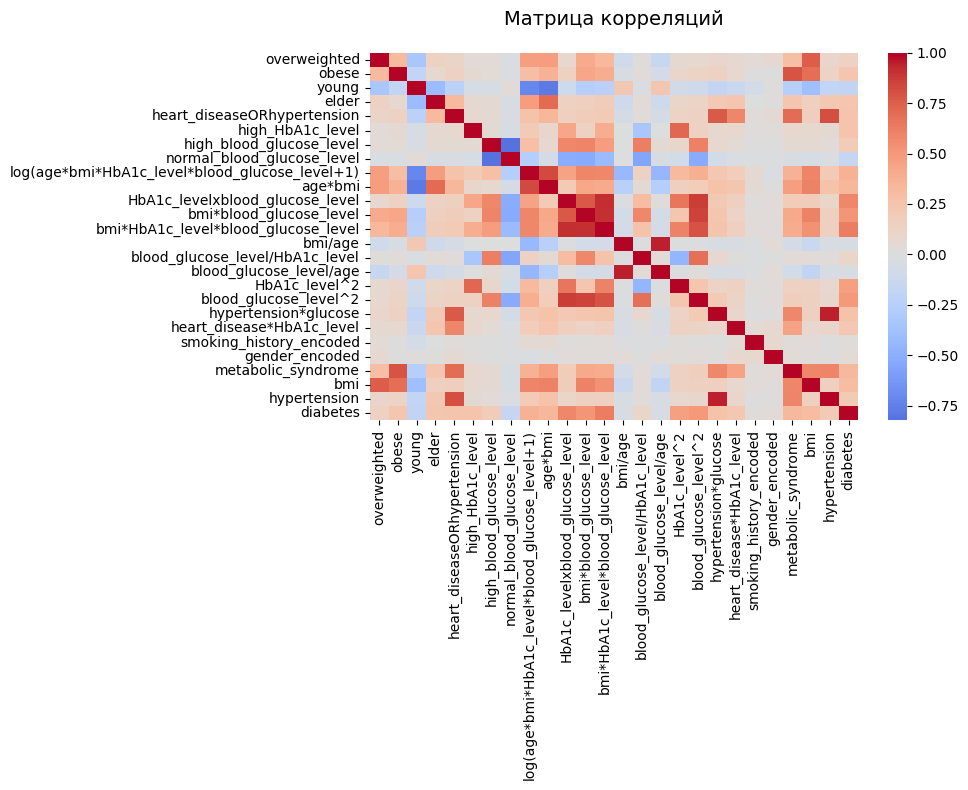

In [30]:
corr_matrix = diabetes_new_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Матрица корреляций', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Посмортим на результат после создания новых фич

Для начала снова подготовим данные

In [31]:

# Разделим выборки на train и test,
# Но т.к. нужно удалить выбросы только, для train выборки, то делаем:

from sklearn.preprocessing import RobustScaler

diabetes_X = diabetes_df.drop('diabetes', axis=1)
diabetes_y = diabetes_df['diabetes']
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes_X,
    diabetes_y,
    test_size=0.2,
    stratify=diabetes_y,
    random_state=42,
)

diabetes_train_df = pd.DataFrame(diabetes_X_train, columns=diabetes_X.columns)
diabetes_train_df['diabetes'] = diabetes_y_train

diabetes_test_df = pd.DataFrame(diabetes_X_test, columns=diabetes_X.columns)
diabetes_test_df['diabetes'] = diabetes_y_test

# Удалим выбросы только для train
diabetes_train_df = remove_outliers_iqr_by_group(diabetes_train_df, 'bmi', 'diabetes')

# Создаем фичи
diabetes_train_df = create_features(diabetes_train_df)
diabetes_test_df = create_features(diabetes_test_df)

# Удалим features, которые имеют высокую корреляцию с другими
diabetes_train_df = drop_highly_correlated_features(diabetes_train_df)
diabetes_test_df = diabetes_test_df[diabetes_train_df.columns]

# Снова отделим target от всех остальных данных
diabetes_X_train = diabetes_train_df.drop('diabetes', axis=1)
diabetes_y_train = diabetes_train_df['diabetes']

diabetes_X_test = diabetes_test_df.drop('diabetes', axis=1)
diabetes_y_test = diabetes_test_df['diabetes']

# Применим RobustScaler, т.к. он устойчив к выбросам
scaler = RobustScaler()
diabetes_X_train = pd.DataFrame(scaler.fit_transform(diabetes_X_train), columns=diabetes_X_train.columns)
diabetes_X_test = pd.DataFrame(scaler.transform(diabetes_X_test), columns=diabetes_X_test.columns)

Кросс-валидация и выбор лучшей модели по fbeta-score (beta = 1,2,3)

In [32]:
import warnings
from sklearn.model_selection import cross_val_score
import optuna

warnings.filterwarnings('ignore', category=UserWarning)
def find_best_hyperparameters_cv(X, y, n_trials=10, cv=5, scoring='accuracy', n_jobs=-1):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
            'random_state': 42
        }
        
        model = DecisionTreeClassifier(**params)
        
        return cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    return study.best_params


best_params = {
    'f1': {'max_depth': 26, 'min_samples_split': 38, 'min_samples_leaf': 8, 'max_features': None, 'splitter': 'best', 'criterion': 'gini'},
    'f2': {'max_depth': 38, 'min_samples_split': 42, 'min_samples_leaf': 1, 'max_features': None, 'splitter': 'best', 'criterion': 'gini'},
    'f3': {'max_depth': 32, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': None, 'splitter': 'best', 'criterion': 'entropy'}
}

for beta in [1, 2, 3]:
    scorer = make_scorer(fbeta_score, beta=beta) 
    if not best_params.get(f'f{beta}'):
        best_params[f'f{beta}'] = find_best_hyperparameters_cv(
            diabetes_X_train,
            diabetes_y_train,
            n_trials=50,
            cv=StratifiedKFold(n_splits=5),
            scoring=scorer
        )
    
    print(f"\n=== Best Model f{beta} on validation ===")
    print(f"Best params: {best_params[f'f{beta}']}")



=== Best Model f1 on validation ===
Best params: {'max_depth': 26, 'min_samples_split': 38, 'min_samples_leaf': 8, 'max_features': None, 'splitter': 'best', 'criterion': 'gini'}

=== Best Model f2 on validation ===
Best params: {'max_depth': 38, 'min_samples_split': 42, 'min_samples_leaf': 1, 'max_features': None, 'splitter': 'best', 'criterion': 'gini'}

=== Best Model f3 on validation ===
Best params: {'max_depth': 32, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': None, 'splitter': 'best', 'criterion': 'entropy'}


/home/jonaj/StudyDir/AI_LABS/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Подберем оптимальный threshold для каждой из моделей и каждой из fbeta метрик

In [33]:
optimal_models = {}      
optimal_thresholds = {}
optimal_fold_scores = {}

for beta in [1, 2, 3]:
    for model_name in [1, 2, 3]:
        model = DecisionTreeClassifier(**best_params[f'f{model_name}'])
        
        model, threshold, fold_score = find_optimal_threshhold_cv(
            model,
            diabetes_X_train,
            diabetes_y_train,
            cv=5,
            f_beta=beta,
            report=True
        )
        if optimal_models.get(f'f{beta}'):
            if fold_score['f_beta_score'] > optimal_fold_scores[f'f{beta}']['f_beta_score']:
                optimal_models[f'f{beta}'] = model
                optimal_thresholds[f'f{beta}'] = threshold
                optimal_fold_scores[f'f{beta}'] = fold_score
        else:
            optimal_models[f'f{beta}'] = model
            optimal_thresholds[f'f{beta}'] = threshold
            optimal_fold_scores[f'f{beta}'] = fold_score


=== Best Model f1 on validation ===
Best fold: 3
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2682
           1       0.95      0.76      0.85       263

    accuracy                           0.98      2945
   macro avg       0.96      0.88      0.92      2945
weighted avg       0.97      0.98      0.97      2945

Best f1-score: 0.8457
Best f2-score: 0.7924
Best f3-score: 0.7761
Best f1-score: 0.8457
Best threshold: 0.6666666666666666

=== Best Model f1 on validation ===
Best fold: 3
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2682
           1       0.90      0.78      0.83       263

    accuracy                           0.97      2945
   macro avg       0.94      0.89      0.91      2945
weighted avg       0.97      0.97      0.97      2945

Best f1-score: 0.8333
Best f2-score: 0.8002
Best f3-score: 0.7897
Best f1-score: 0.8333
Best threshold: 0.6666666666666666


Посмотрим, что получилось на валидации

In [34]:
for beta in [1, 2, 3]:
    print(optimal_fold_scores[f'f{beta}']['classification_report'])
    print(f"Best f{beta}-score: {optimal_fold_scores[f'f{beta}']['f_beta_score']:.4f}")
    

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2682
           1       0.95      0.76      0.85       263

    accuracy                           0.98      2945
   macro avg       0.96      0.88      0.92      2945
weighted avg       0.97      0.98      0.97      2945

Best f1-score: 0.8457
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2682
           1       0.67      0.85      0.75       263

    accuracy                           0.95      2945
   macro avg       0.83      0.91      0.86      2945
weighted avg       0.96      0.95      0.95      2945

Best f2-score: 0.8087
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      2682
           1       0.47      0.91      0.62       263

    accuracy                           0.90      2945
   macro avg       0.73      0.91      0.78      2945
weighted avg       0.94      0

Проведем замеры на тестовой выборке

In [35]:
for beta in [1, 2, 3]:
    model = optimal_models[f'f{beta}']
    threshold = optimal_thresholds[f'f{beta}']
    
    y_prob_test = model.predict_proba(diabetes_X_test)[:, 1]
    y_pred_test = (y_prob_test >= threshold).astype(int)
    
    print(f"\n=== Test Model f{beta} ===")
    print(classification_report(diabetes_y_test, y_pred_test))
    print(f"f1-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=1):.4f}")
    print(f"f2-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=2):.4f}")
    print(f"f3-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=3):.4f}")
    print(f"f{beta}-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=beta):.4f}")
    print(f"threshold: {threshold}")


=== Test Model f1 ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3660
           1       0.81      0.76      0.78       340

    accuracy                           0.96      4000
   macro avg       0.89      0.87      0.88      4000
weighted avg       0.96      0.96      0.96      4000

f1-score: 0.7837
f2-score: 0.7704
f3-score: 0.7660
f1-score: 0.7837
threshold: 0.6666666666666666

=== Test Model f2 ===
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      3660
           1       0.48      0.86      0.62       340

    accuracy                           0.91      4000
   macro avg       0.73      0.89      0.78      4000
weighted avg       0.94      0.91      0.92      4000

f1-score: 0.6151
f2-score: 0.7439
f3-score: 0.7998
f2-score: 0.7439
threshold: 0.1935483870967742

=== Test Model f3 ===
              precision    recall  f1-score   support

           0       0.99   

| Модель | Класс | Precision | Recall | F1-Score | Support | F-метрики |
|--------|-------|-----------|--------|----------|---------|----------------------|
| **Test Model f1** | **0** | 0.98 | 0.98 | 0.98 | 3660 |  |
| **(threshold: 0.667)** | **1** | 0.81 | 0.76 | 0.78 | 340 | |
| |       |      |      |      |     |                      |
| | **Macro Avg** | 0.89 | 0.87 | 0.88 | 4000 | **F1-score: 0.7837** |
| | **Weighted Avg** | 0.96 | 0.96 | 0.96 | 4000 | **F2-score: 0.7704** |
| | **Accuracy** | — | — | 0.96 | 4000 | **F3-score: 0.7660** |
| |       |      |      |      |     |   |
| **Test Model f2** | **0** | 0.99 | 0.91 | 0.95 | 3660 |  |
| **(threshold: 0.194)** | **1** | 0.48 | 0.86 | 0.62 | 340 |  |
| |       |      |      |      |     |                      |
| | **Macro Avg** | 0.73 | 0.89 | 0.78 | 4000 | **F1-score: 0.6151** |
| | **Weighted Avg** | 0.94 | 0.91 | 0.92 | 4000 | **F2-score: 0.7439** |
| | **Accuracy** | — | — | 0.91 | 4000 | **F3-score: 0.7998** |
| |       |      |      |      |     |                      |
| **Test Model f3** | **0** | 0.99 | 0.85 | 0.91 | 3660 |  |
| **(threshold: 0.056)**| **1** | 0.36 | 0.90 | 0.51 | 340 |  |
| |       |      |      |      |     |                      |
| | **Macro Avg** | 0.67 | 0.88 | 0.71 | 4000 | **F1-score: 0.5112** |
| | **Weighted Avg** | 0.94 | 0.85 | 0.88 | 4000 | **F2-score: 0.6911** |
| | **Accuracy** | — | — | 0.85 | 4000 | **F3-score: 0.7830** |

#### Вывод:

После обработки данных и оптимизации гиперпараметров через Optuna качество моделей значительно улучшилось. Модель F1 достигла показателя 0.7837 (+6%) с более сбалансированными Precision (0.81) и Recall (0.76). Для F2 и F3 удалось получить высокий Recall (86% и 90%) при снижении Precision, что соответствует ожиданиям при увеличении веса recall в метрике. 

### 4.  Имплементация алгоритма машинного обучения 

4.1. Задача классификации

In [36]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y
from scipy import stats

class LabDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    
    class Node:
        def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
            self.feature_idx = feature_idx
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value
    
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1, 
                 max_features=None, splitter='best', criterion='gini', random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.splitter = splitter
        self.criterion = criterion
        self.random_state = random_state
        
        if random_state is not None:
            np.random.seed(random_state)
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        y = y.astype(int)
        
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        self.n_features_in_ = X.shape[1]
        
        self.root = self._build_tree(X, y, depth=0)
        return self

    def _get_feature_indices(self, n_features):
        if self.max_features is None:
            return np.arange(n_features)
        elif self.max_features == 'sqrt':
            n = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            n = max(1, int(np.log2(n_features)))
        elif isinstance(self.max_features, int):
            n = min(self.max_features, n_features)
        elif isinstance(self.max_features, float):
            n = max(1, int(self.max_features * n_features))
        else:
            n = n_features
        n = max(1, min(n, n_features))
        return np.random.choice(n_features, size=n, replace=False)

    def _build_tree(self, X, y, depth):
        n_samples = X.shape[0]
        
        if (depth >= self.max_depth or 
            n_samples < self.min_samples_split or 
            np.all(y == y[0])):
            return self.Node(value=self._leaf_value(y))
        
        feature_indices = self._get_feature_indices(X.shape[1])
        
        if self.splitter == 'best':
            best_feature, best_threshold = self._find_best_split(X, y, feature_indices)
        else:
            best_feature, best_threshold = self._find_random_split(X, y, feature_indices)
        
        if best_feature is None:
            return self.Node(value=self._leaf_value(y))
        
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
            return self.Node(value=self._leaf_value(y))
        
        left_node = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_node = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return self.Node(feature_idx=best_feature, threshold=best_threshold,
                         left=left_node, right=right_node)

    def _find_best_split(self, X, y, feature_indices):
        best_gain = -np.inf
        best_feature = None
        best_threshold = None
        n_total = y.size
        
        parent_impurity = self._calculate_impurity(y)
        
        for fid in feature_indices:
            feature = X[:, fid]
            if np.all(feature == feature[0]):
                continue
            
            sort_idx = np.argsort(feature)
            y_sorted = y[sort_idx]
            x_sorted = feature[sort_idx]
            
            valid_splits = np.where(x_sorted[1:] != x_sorted[:-1])[0] + 1
            if valid_splits.size == 0:
                continue
            
            valid_splits = valid_splits[
                (valid_splits >= self.min_samples_leaf) & 
                (n_total - valid_splits >= self.min_samples_leaf)
            ]
            if valid_splits.size == 0:
                continue
            
            for i in valid_splits:
                left_y = y_sorted[:i]
                right_y = y_sorted[i:]
                
                left_impurity = self._calculate_impurity(left_y)
                right_impurity = self._calculate_impurity(right_y)
                
                weighted_impurity = (len(left_y) * left_impurity + len(right_y) * right_impurity) / n_total
                gain = parent_impurity - weighted_impurity
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = fid
                    best_threshold = (x_sorted[i - 1] + x_sorted[i]) / 2.0
        
        return best_feature, best_threshold

    def _calculate_impurity(self, y):
        n_samples = y.size
        if n_samples == 0:
            return 0
        
        counts = np.bincount(y, minlength=self.n_classes_)
        probabilities = counts / n_samples
        
        if self.criterion == 'gini':
            return 1.0 - np.sum(probabilities ** 2)
        elif self.criterion == 'entropy':
            return stats.entropy(probabilities[probabilities > 0])
        elif self.criterion == 'log_loss':
            return stats.entropy(probabilities[probabilities > 0])
        else:
            return 1.0 - np.max(probabilities)

    def _find_random_split(self, X, y, feature_indices):
        fid = np.random.choice(feature_indices)
        col = X[:, fid]
        if np.all(col == col[0]):
            return None, None
        threshold = np.random.uniform(col.min(), col.max())
        return fid, threshold

    def _leaf_value(self, y):
        counts = np.bincount(y, minlength=self.n_classes_)
        probs = counts / y.size
        return probs

    def predict(self, X):
        X = np.asarray(X, dtype=np.float64)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        probs = self.predict_proba(X)
        return self.classes_[np.argmax(probs, axis=1)]

    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float64)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        probs = np.empty((X.shape[0], self.n_classes_), dtype=np.float64)
        for i in range(X.shape[0]):
            node = self.root
            while node.value is None:
                if X[i, node.feature_idx] <= node.threshold:
                    node = node.left
                else:
                    node = node.right
            probs[i] = node.value
        return probs

Проверим работоспособность этого класса

Повторим все действия снова

Сначала с простым бейзлайном

In [37]:
gender_dummies = pd.get_dummies(diabetes_df['gender'], drop_first=True)
smoking_history_dummies = pd.get_dummies(diabetes_df['smoking_history'], drop_first=True)
onehot_diabetes_df = pd.concat([diabetes_df, gender_dummies, smoking_history_dummies], axis=1)

onehot_diabetes_df.drop(['gender', 'smoking_history'], axis=1, inplace=True)
diabetes_X = onehot_diabetes_df.drop('diabetes', axis=1)
diabetes_y = onehot_diabetes_df['diabetes']
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes_X,
    diabetes_y,
    test_size=0.2,
    stratify=diabetes_y,
    random_state=42
)

In [38]:
model = LabDecisionTreeClassifier(max_depth=20)

optimal_models = {}      
optimal_thresholds = {}
optimal_fold_scores = {}

for beta in [1, 2, 3]:
    optimal_models[f'f{beta}'], optimal_thresholds[f'f{beta}'], optimal_fold_scores[f'f{beta}'] = find_optimal_threshhold_cv(
        model,
        diabetes_X_train,
        diabetes_y_train,
        cv=5,
        f_beta=beta,
        report=True
    )


=== Best Model f1 on validation ===
Best fold: 4
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2928
           1       0.73      0.74      0.74       272

    accuracy                           0.96      3200
   macro avg       0.86      0.86      0.86      3200
weighted avg       0.96      0.96      0.96      3200

Best f1-score: 0.7386
Best f2-score: 0.7410
Best f3-score: 0.7418
Best f1-score: 0.7386
Best threshold: 1.0

=== Best Model f2 on validation ===
Best fold: 4
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2928
           1       0.73      0.74      0.74       272

    accuracy                           0.96      3200
   macro avg       0.86      0.86      0.86      3200
weighted avg       0.96      0.96      0.96      3200

Best f1-score: 0.7386
Best f2-score: 0.7410
Best f3-score: 0.7418
Best f2-score: 0.7410
Best threshold: 1.0

=== Best Model f3 on validati

Проведем замеры на тестовой выборке

In [39]:
for f_score in [1, 2, 3]:
    model = optimal_models[f'f{f_score}']
    threshold = optimal_thresholds[f'f{f_score}']
    
    y_prob_test = model.predict_proba(diabetes_X_test)[:, 1]
    y_pred_test = (y_prob_test >= threshold).astype(int)
    
    print(f"\n=== Test Model f{f_score} ===")
    print(classification_report(diabetes_y_test, y_pred_test))
    print(f"f1-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=1):.4f}")
    print(f"f2-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=2):.4f}")
    print(f"f3-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=3):.4f}")
    print(f"f{f_score}-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=f_score):.4f}") 


=== Test Model f1 ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3660
           1       0.76      0.75      0.76       340

    accuracy                           0.96      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.96      0.96      0.96      4000

f1-score: 0.7552
f2-score: 0.7538
f3-score: 0.7534
f1-score: 0.7552

=== Test Model f2 ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3660
           1       0.76      0.75      0.76       340

    accuracy                           0.96      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.96      0.96      0.96      4000

f1-score: 0.7552
f2-score: 0.7538
f3-score: 0.7534
f2-score: 0.7538

=== Test Model f3 ===
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3660
           1       0.61      0.7

| Модель | Класс | Precision | Recall | F1-Score | Support | F-метрики |
|--------|-------|-----------|--------|----------|---------|----------------------|
| **Test Model f1** | **0** | 0.98 | 0.98 | 0.98 | 3660 | |
| | **1** | 0.76 | 0.75 | 0.76 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.87 | 0.87 | 0.87 | 4000 | **F1-score: 0.7552** |
| | **Weighted Avg** | 0.96 | 0.96 | 0.96 | 4000 | **F2-score: 0.7538** |
| | **Accuracy** | — | — | 0.96 | 4000 | **F3-score: 0.7534** |
| | | | | | | |
| **Test Model f2** | **0** | 0.98 | 0.98 | 0.98 | 3660 | |
| | **1** | 0.76 | 0.75 | 0.76 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.87 | 0.87 | 0.87 | 4000 | **F1-score: 0.7552** |
| | **Weighted Avg** | 0.96 | 0.96 | 0.96 | 4000 | **F2-score: 0.7538** |
| | **Accuracy** | — | — | 0.96 | 4000 | **F3-score: 0.7534** |
| | | | | | | |
| **Test Model f3** | **0** | 0.98 | 0.95 | 0.97 | 3660 | |
| | **1** | 0.61 | 0.78 | 0.68 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.80 | 0.87 | 0.83 | 4000 | **F1-score: 0.6848** |
| | **Weighted Avg** | 0.95 | 0.94 | 0.94 | 4000 | **F2-score: 0.7370** |
| | **Accuracy** | — | — | 0.94 | 4000 | **F3-score: 0.7562** |

#### Вывод:

Реализованный класс LabDecisionTreeClassifier успешно воспроизводит основные функции библиотечного DecisionTreeClassifier. Cобственная реализация показала практически идентичные результаты с sklearn. Небольшие расхождения объясняются особенностями реализации алгоритмов поиска разбиений и вычисления информационных критериев.

Теперь улучшим бейзлайн

In [40]:
diabetes_X = diabetes_df.drop('diabetes', axis=1)
diabetes_y = diabetes_df['diabetes']
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes_X,
    diabetes_y,
    test_size=0.2,
    stratify=diabetes_y,
    random_state=42
)

diabetes_train_df = pd.DataFrame(diabetes_X_train, columns=diabetes_X.columns)
diabetes_train_df['diabetes'] = diabetes_y_train

diabetes_test_df = pd.DataFrame(diabetes_X_test, columns=diabetes_X.columns)
diabetes_test_df['diabetes'] = diabetes_y_test

# Удалим выбросы только для train
diabetes_train_df = remove_outliers_iqr_by_group(diabetes_train_df, 'bmi', 'diabetes')

# Создаем фичи
diabetes_train_df = create_features(diabetes_train_df)
diabetes_test_df = create_features(diabetes_test_df)

# Удалим features, которые имеют высокую корреляцию с другими
diabetes_train_df = drop_highly_correlated_features(diabetes_train_df)
diabetes_test_df = diabetes_test_df[diabetes_train_df.columns]

# Снова отделим target от всех остальных данных
diabetes_X_train = diabetes_train_df.drop('diabetes', axis=1)
diabetes_y_train = diabetes_train_df['diabetes']

diabetes_X_test = diabetes_test_df.drop('diabetes', axis=1)
diabetes_y_test = diabetes_test_df['diabetes']

# Применим RobustScaler, т.к. он устойчив к выбросам
scaler = RobustScaler()
diabetes_X_train = pd.DataFrame(scaler.fit_transform(diabetes_X_train), columns=diabetes_X_train.columns)
diabetes_X_test = pd.DataFrame(scaler.transform(diabetes_X_test), columns=diabetes_X_test.columns)

Подберем гиперпараметры

In [41]:
import warnings
from sklearn.model_selection import cross_val_score
import optuna

warnings.filterwarnings('ignore', category=UserWarning)
def find_best_hyperparameters_cv(X, y, n_trials=10, cv=5, scoring='accuracy', n_jobs=-1):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
            'random_state': 42
        }
        
        model = LabDecisionTreeClassifier(**params)
        
        return cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    return study.best_params


best_params = {
    'f1': {'max_depth': 26, 'min_samples_split': 38, 'min_samples_leaf': 8, 'max_features': None, 'splitter': 'best', 'criterion': 'gini'},
    'f2': {'max_depth': 38, 'min_samples_split': 42, 'min_samples_leaf': 1, 'max_features': None, 'splitter': 'best', 'criterion': 'gini'},
    'f3': {'max_depth': 32, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': None, 'splitter': 'best', 'criterion': 'entropy'}
}

for beta in [1, 2, 3]:
    scorer = make_scorer(fbeta_score, beta=beta) 
    if not best_params.get(f'f{beta}'):
        best_params[f'f{beta}'] = find_best_hyperparameters_cv(
            diabetes_X_train,
            diabetes_y_train,
            n_trials=50,
            cv=StratifiedKFold(n_splits=5),
            scoring=scorer
        )
    
    print(f"\n=== Best Model f{beta} on validation ===")
    print(f"Best params: {best_params[f'f{beta}']}")



=== Best Model f1 on validation ===
Best params: {'max_depth': 26, 'min_samples_split': 38, 'min_samples_leaf': 8, 'max_features': None, 'splitter': 'best', 'criterion': 'gini'}

=== Best Model f2 on validation ===
Best params: {'max_depth': 38, 'min_samples_split': 42, 'min_samples_leaf': 1, 'max_features': None, 'splitter': 'best', 'criterion': 'gini'}

=== Best Model f3 on validation ===
Best params: {'max_depth': 32, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': None, 'splitter': 'best', 'criterion': 'entropy'}


In [42]:
optimal_models = {}      
optimal_thresholds = {}
optimal_fold_scores = {}

for beta in [1, 2, 3]:
    for model_name in [1, 2, 3]:
        model = LabDecisionTreeClassifier(**best_params[f'f{model_name}'])
        
        model, threshold, fold_score = find_optimal_threshhold_cv(
            model,
            diabetes_X_train,
            diabetes_y_train,
            cv=5,
            f_beta=beta,
            report=True
        )
        if optimal_models.get(f'f{beta}'):
            if fold_score['f_beta_score'] > optimal_fold_scores[f'f{beta}']['f_beta_score']:
                optimal_models[f'f{beta}'] = model
                optimal_thresholds[f'f{beta}'] = threshold
                optimal_fold_scores[f'f{beta}'] = fold_score
        else:
            optimal_models[f'f{beta}'] = model
            optimal_thresholds[f'f{beta}'] = threshold
            optimal_fold_scores[f'f{beta}'] = fold_score


=== Best Model f1 on validation ===
Best fold: 3
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2682
           1       0.95      0.76      0.85       263

    accuracy                           0.98      2945
   macro avg       0.96      0.88      0.92      2945
weighted avg       0.97      0.98      0.97      2945

Best f1-score: 0.8457
Best f2-score: 0.7924
Best f3-score: 0.7761
Best f1-score: 0.8457
Best threshold: 0.6666666666666666

=== Best Model f1 on validation ===
Best fold: 3
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2682
           1       0.90      0.78      0.83       263

    accuracy                           0.97      2945
   macro avg       0.94      0.89      0.91      2945
weighted avg       0.97      0.97      0.97      2945

Best f1-score: 0.8333
Best f2-score: 0.8002
Best f3-score: 0.7897
Best f1-score: 0.8333
Best threshold: 0.6666666666666666


Посмотрим, что получилось на валидации

In [43]:
for beta in [1, 2, 3]:
    print(optimal_fold_scores[f'f{beta}']['classification_report'])
    print(f"Best f{beta}-score: {optimal_fold_scores[f'f{beta}']['f_beta_score']:.4f}")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2682
           1       0.95      0.76      0.85       263

    accuracy                           0.98      2945
   macro avg       0.96      0.88      0.92      2945
weighted avg       0.97      0.98      0.97      2945

Best f1-score: 0.8457
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2682
           1       0.67      0.85      0.75       263

    accuracy                           0.95      2945
   macro avg       0.83      0.91      0.86      2945
weighted avg       0.96      0.95      0.95      2945

Best f2-score: 0.8087
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      2682
           1       0.47      0.91      0.62       263

    accuracy                           0.90      2945
   macro avg       0.73      0.91      0.78      2945
weighted avg       0.94      0

Проведем замеры на тестовой выборке

In [44]:
for beta in [1, 2, 3]:
    model = optimal_models[f'f{beta}']
    threshold = optimal_thresholds[f'f{beta}']
    
    y_prob_test = model.predict_proba(diabetes_X_test)[:, 1]
    y_pred_test = (y_prob_test >= threshold).astype(int)
    
    print(f"\n=== Test Model f{beta} ===")
    print(classification_report(diabetes_y_test, y_pred_test))
    print(f"f1-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=1):.4f}")
    print(f"f2-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=2):.4f}")
    print(f"f3-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=3):.4f}")
    print(f"f{beta}-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=beta):.4f}")
    print(f"threshold: {threshold}")


=== Test Model f1 ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3660
           1       0.81      0.76      0.78       340

    accuracy                           0.96      4000
   macro avg       0.89      0.87      0.88      4000
weighted avg       0.96      0.96      0.96      4000

f1-score: 0.7837
f2-score: 0.7704
f3-score: 0.7660
f1-score: 0.7837
threshold: 0.6666666666666666

=== Test Model f2 ===
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      3660
           1       0.48      0.86      0.62       340

    accuracy                           0.91      4000
   macro avg       0.73      0.89      0.78      4000
weighted avg       0.94      0.91      0.92      4000

f1-score: 0.6151
f2-score: 0.7439
f3-score: 0.7998
f2-score: 0.7439
threshold: 0.1935483870967742

=== Test Model f3 ===
              precision    recall  f1-score   support

           0       0.99   

| Модель | Класс | Precision | Recall | F1-Score | Support | F-метрики |
|--------|-------|-----------|--------|----------|---------|----------------------|
| **Test Model f1** | **0** | 0.98 | 0.98 | 0.98 | 3660 | |
| **(threshold: 0.667)** | **1** | 0.81 | 0.76 | 0.78 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.89 | 0.87 | 0.88 | 4000 | **F1-score: 0.7837** |
| | **Weighted Avg** | 0.96 | 0.96 | 0.96 | 4000 | **F2-score: 0.7704** |
| | **Accuracy** | — | — | 0.96 | 4000 | **F3-score: 0.7660** |
| | | | | | | |
| **Test Model f2** | **0** | 0.99 | 0.91 | 0.95 | 3660 | |
| **(threshold: 0.194)** | **1** | 0.48 | 0.86 | 0.62 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.73 | 0.89 | 0.78 | 4000 | **F1-score: 0.6151** |
| | **Weighted Avg** | 0.94 | 0.91 | 0.92 | 4000 | **F2-score: 0.7439** |
| | **Accuracy** | — | — | 0.91 | 4000 | **F3-score: 0.7998** |
| | | | | | | |
| **Test Model f3** | **0** | 0.99 | 0.85 | 0.91 | 3660 | |
| **(threshold: 0.056)**| **1** | 0.36 | 0.90 | 0.51 | 340 | |
| | | | | | | |
| | **Macro Avg** | 0.67 | 0.88 | 0.71 | 4000 | **F1-score: 0.5100** |
| | **Weighted Avg** | 0.94 | 0.85 | 0.88 | 4000 | **F2-score: 0.6902** |
| | **Accuracy** | — | — | 0.85 | 4000 | **F3-score: 0.7824** |

#### Вывод:

Реализованный класс LabDecisionTreeClassifier успешно воспроизводит основные функции библиотечного DecisionTreeClassifier. После улучшений результаты практически идентичны sklearn-версии (F1=0.7837). Небольшие расхождения объясняются особенностями реализации алгоритмов поиска разбиений и вычисления информационных критериев.

## Задача регрессии

#### 2.1. Обучение моделей из sklearn для решения задачи регрессии и оценка качества по выбранным метрикам.

Подключим необходимые модули

In [51]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

Загрузим датасет и посмотрим, что он из себя представляет

In [52]:
honey_df = pd.read_csv("datasets/honey_purity_dataset.csv")
# Датасет состоит из 247_903 строк. 
# Чтобы сократить время ожидания обучения модели возьмем 20_000 строк.
# Конечно, это ухудшит качество моделей, но для ЛР это не критично.
honey_df = honey_df.sample(n=20000, random_state=42)
honey_df.head()

,CS,Density,WC,pH,EC,F,G,Pollen_analysis,Viscosity,Purity,Price
29002,7.73,1.45,15.07,7.42,0.76,26.78,24.60,Lavender,6395.02,0.64,384.48
13563,6.49,1.61,20.81,7.27,0.74,31.43,27.41,Wildflower,6565.61,0.99,319.27
12445,2.70,1.64,12.85,3.58,0.70,34.54,27.17,Eucalyptus,7176.79,0.84,584.69
233689,8.39,1.55,14.51,5.34,0.77,33.67,23.27,Borage,2152.04,0.63,469.07
52643,8.28,1.46,13.56,4.61,0.77,35.10,43.78,Alfalfa,6417.87,0.82,353.38


Посмотрим информацию о датасете

In [53]:
print(honey_df.info())
honey_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 29002 to 192074
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CS               20000 non-null  float64
 1   Density          20000 non-null  float64
 2   WC               20000 non-null  float64
 3   pH               20000 non-null  float64
 4   EC               20000 non-null  float64
 5   F                20000 non-null  float64
 6   G                20000 non-null  float64
 7   Pollen_analysis  20000 non-null  object 
 8   Viscosity        20000 non-null  float64
 9   Purity           20000 non-null  float64
 10  Price            20000 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.8+ MB
None


,CS,Density,WC,pH,EC,F,G,Viscosity,Purity,Price
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,5.500674,1.534812,18.509555,5.012265,0.799931,34.967516,32.480927,5747.197491,0.824037,592.185096
std,2.589717,0.188816,3.758893,1.436138,0.057727,8.609815,7.222069,2461.760308,0.139510,233.332055
min,1.000000,1.210000,12.000000,2.500000,0.700000,20.000000,20.000000,1500.920000,0.610000,128.720000
25%,3.290000,1.370000,15.237500,3.780000,0.750000,27.540000,26.290000,3600.425000,0.660000,432.620000
50%,5.500000,1.530000,18.550000,5.020000,0.800000,34.975000,32.360000,5743.140000,0.820000,612.190000
75%,7.750000,1.700000,21.770000,6.250000,0.850000,42.380000,38.802500,7883.825000,0.970000,769.550000
max,10.000000,1.860000,25.000000,7.500000,0.900000,50.000000,45.000000,9999.280000,1.000000,976.690000


Посмотрим сколько у нас null столбцев

In [54]:
honey_df.isnull().sum()

CS                 0
Density            0
WC                 0
pH                 0
EC                 0
F                  0
G                  0
Pollen_analysis    0
Viscosity          0
Purity             0
Price              0
dtype: int64

Посмотрим сколько у нас повторяющихся строк

In [55]:
honey_df.duplicated().sum()

np.int64(0)

Посмотрим информацию о категориальных данных

In [56]:
print(honey_df['Pollen_analysis'].value_counts())

Pollen_analysis
Sunflower         1090
Eucalyptus        1086
Orange Blossom    1083
Sage              1078
Lavender          1075
Heather           1075
Buckwheat         1073
Tupelo            1068
Clover            1066
Acacia            1054
Wildflower        1045
Avocado           1045
Chestnut          1044
Alfalfa           1042
Thyme             1032
Rosemary          1025
Borage            1016
Blueberry         1008
Manuka             995
Name: count, dtype: int64


Сделаем минимально необходимую обработку и обучим модели: 

In [57]:

pollen_analysis = pd.get_dummies(honey_df['Pollen_analysis'], drop_first=True)

onehot_honey_df = pd.concat([honey_df.drop('Pollen_analysis', axis=1), pollen_analysis], axis=1)


onehot_honey_df.head()

,CS,Density,WC,pH,EC,F,G,Viscosity,Purity,Price,...,Heather,Lavender,Manuka,Orange Blossom,Rosemary,Sage,Sunflower,Thyme,Tupelo,Wildflower
29002,7.73,1.45,15.07,7.42,0.76,26.78,24.60,6395.02,0.64,384.48,...,False,True,False,False,False,False,False,False,False,False
13563,6.49,1.61,20.81,7.27,0.74,31.43,27.41,6565.61,0.99,319.27,...,False,False,False,False,False,False,False,False,False,True
12445,2.70,1.64,12.85,3.58,0.70,34.54,27.17,7176.79,0.84,584.69,...,False,False,False,False,False,False,False,False,False,False
233689,8.39,1.55,14.51,5.34,0.77,33.67,23.27,2152.04,0.63,469.07,...,False,False,False,False,False,False,False,False,False,False
52643,8.28,1.46,13.56,4.61,0.77,35.10,43.78,6417.87,0.82,353.38,...,False,False,False,False,False,False,False,False,False,False


Разделим датафрейм на features и target, а также train и test

In [58]:
honey_X = onehot_honey_df.drop(['Purity', 'Price'], axis=1)
honey_y = onehot_honey_df[['Purity', 'Price']]

honey_X_train, honey_X_test, honey_y_train, honey_y_test = train_test_split(
    honey_X,
    honey_y,
    test_size=0.2,
    random_state=42
)

Кросс-валидация

In [59]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor


scoring = {
    'neg_mse': 'neg_mean_squared_error',
    'neg_rmse': 'neg_root_mean_squared_error', 
    'neg_mae': 'neg_mean_absolute_error',   
    'r2' : 'r2',  
}

model = DecisionTreeRegressor()

results = {}

for model_name in ['Purity', 'Price']:
    cv_results = cross_validate(
        model,
        honey_X_train,
        honey_y_train[model_name],
        return_estimator=True,
        scoring=scoring,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    results[model_name] = cv_results
    results_df = pd.DataFrame(cv_results)
    print(f"\nРезультаты кросс-валидации для {model_name} модели:")
    print(results_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Результаты кросс-валидации для Purity модели:
   fit_time  score_time                estimator  test_neg_mse  test_neg_rmse  \
0  0.105035    0.002529  DecisionTreeRegressor()     -0.000877      -0.029622   
1  0.103860    0.003586  DecisionTreeRegressor()     -0.000864      -0.029397   
2  0.104500    0.003844  DecisionTreeRegressor()     -0.001012      -0.031818   
3  0.104234    0.002811  DecisionTreeRegressor()     -0.000887      -0.029789   
4  0.108497    0.003855  DecisionTreeRegressor()     -0.000800      -0.028281   

   test_neg_mae   test_r2  
0     -0.006553  0.955201  
1     -0.006647  0.955870  
2     -0.006772  0.947591  
3     -0.006366  0.953506  
4     -0.005963  0.958767  

Результаты кросс-валидации для Price модели:
   fit_time  score_time                estimator  test_neg_mse  test_neg_rmse  \
0  0.145500    0.003661  DecisionTreeRegressor()  -5538.905833     -74.423826   
1  0.148017    0.003883  DecisionTreeRegressor()  -5117.845868     -71.539121   
2  0.1497

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Посмотрим результат на тестовой выборке, усреднив результат всех моделей

In [61]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

preds = {}

for model_name in ['Purity', 'Price']:
    all_preds = []
    for model in results[model_name]['estimator']:
        pred = model.predict(honey_X_test)
        all_preds.append(pred)
    preds[model_name] = np.mean(all_preds, axis=0)
    
print("Test_score Purity:")
print('r2:', r2_score(honey_y_test['Purity'], preds['Purity']))
print('mse:', mean_squared_error(honey_y_test['Purity'], preds['Purity']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Purity'], preds['Purity'])))
print('mae:', mean_absolute_error(honey_y_test['Purity'], preds['Purity']))

print("\nTest_score Price:")
print('r2:', r2_score(honey_y_test['Price'], preds['Price']))
print('mse:', mean_squared_error(honey_y_test['Price'], preds['Price']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Price'], preds['Price'])))
print('mae:', mean_absolute_error(honey_y_test['Price'], preds['Price']))

Test_score Purity:
r2: 0.9717900514327639
mse: 0.0005561119999999999
rmse: 0.023582027054517597
mae: 0.006002000000000134

Test_score Price:
r2: 0.9415283642568424
mse: 3160.864834322
rmse: 56.22156912006281
mae: 27.749460000000056


| Метрика          | Purity           | Price            |
|------------------|------------------|------------------|
| r2               | 0.97179          | 0.94153          |
| mse              | 0.00056          | 3160.86483       |
| rmse             | 0.02358          | 56.22157         |
| mae              | 0.00600          | 27.74946         |

#### Выводы:

Решающее дерево (sklearn) для регрессии показало высокую точность на обоих таргетах (Purity: r2=0.97179, Price: r2=0.94153). Модель хорошо улавливает зависимости в данных, даже без генерации дополнительных признаков и тонкой настройки гиперпараметров.



### 3. Улучшение бейзлайна

#### 3.2. Задача регрессии

Проведем более детальный анализ датасета

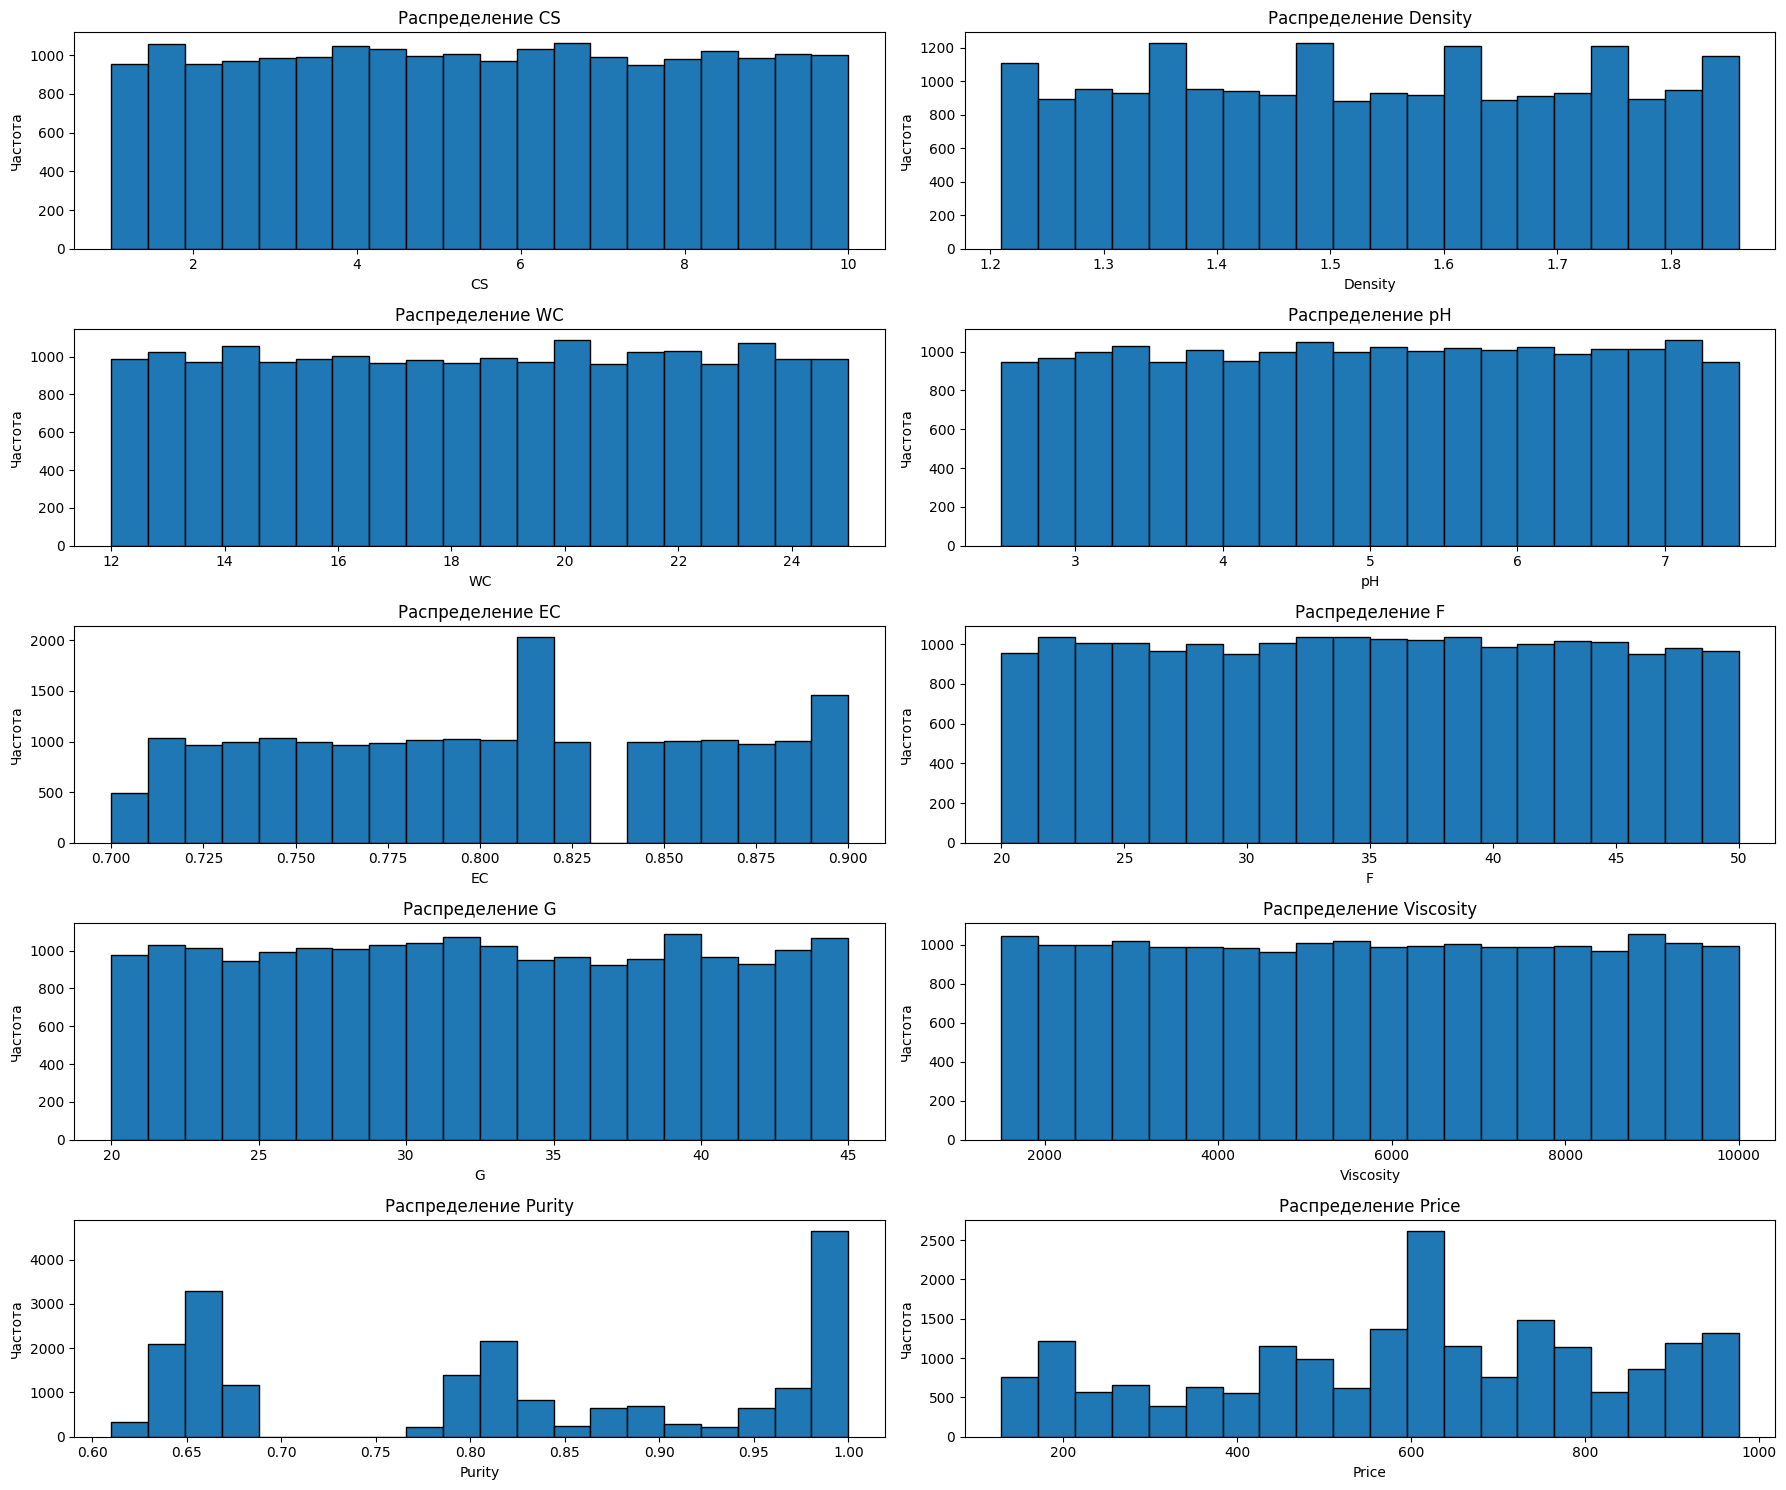

In [62]:
from matplotlib import pyplot as plt


num_cols = ['CS', 'Density', 'WC', 'pH', 'EC', 'F', 'G', 'Viscosity', 'Purity', 'Price']
cat_cols = ['Pollen_analysis']

fig, axes = plt.subplots(5, 2, figsize=(18, 15))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    axes[i].hist(honey_df[col], bins=20, edgecolor='black')
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

Посмотрим есть ли выбросы

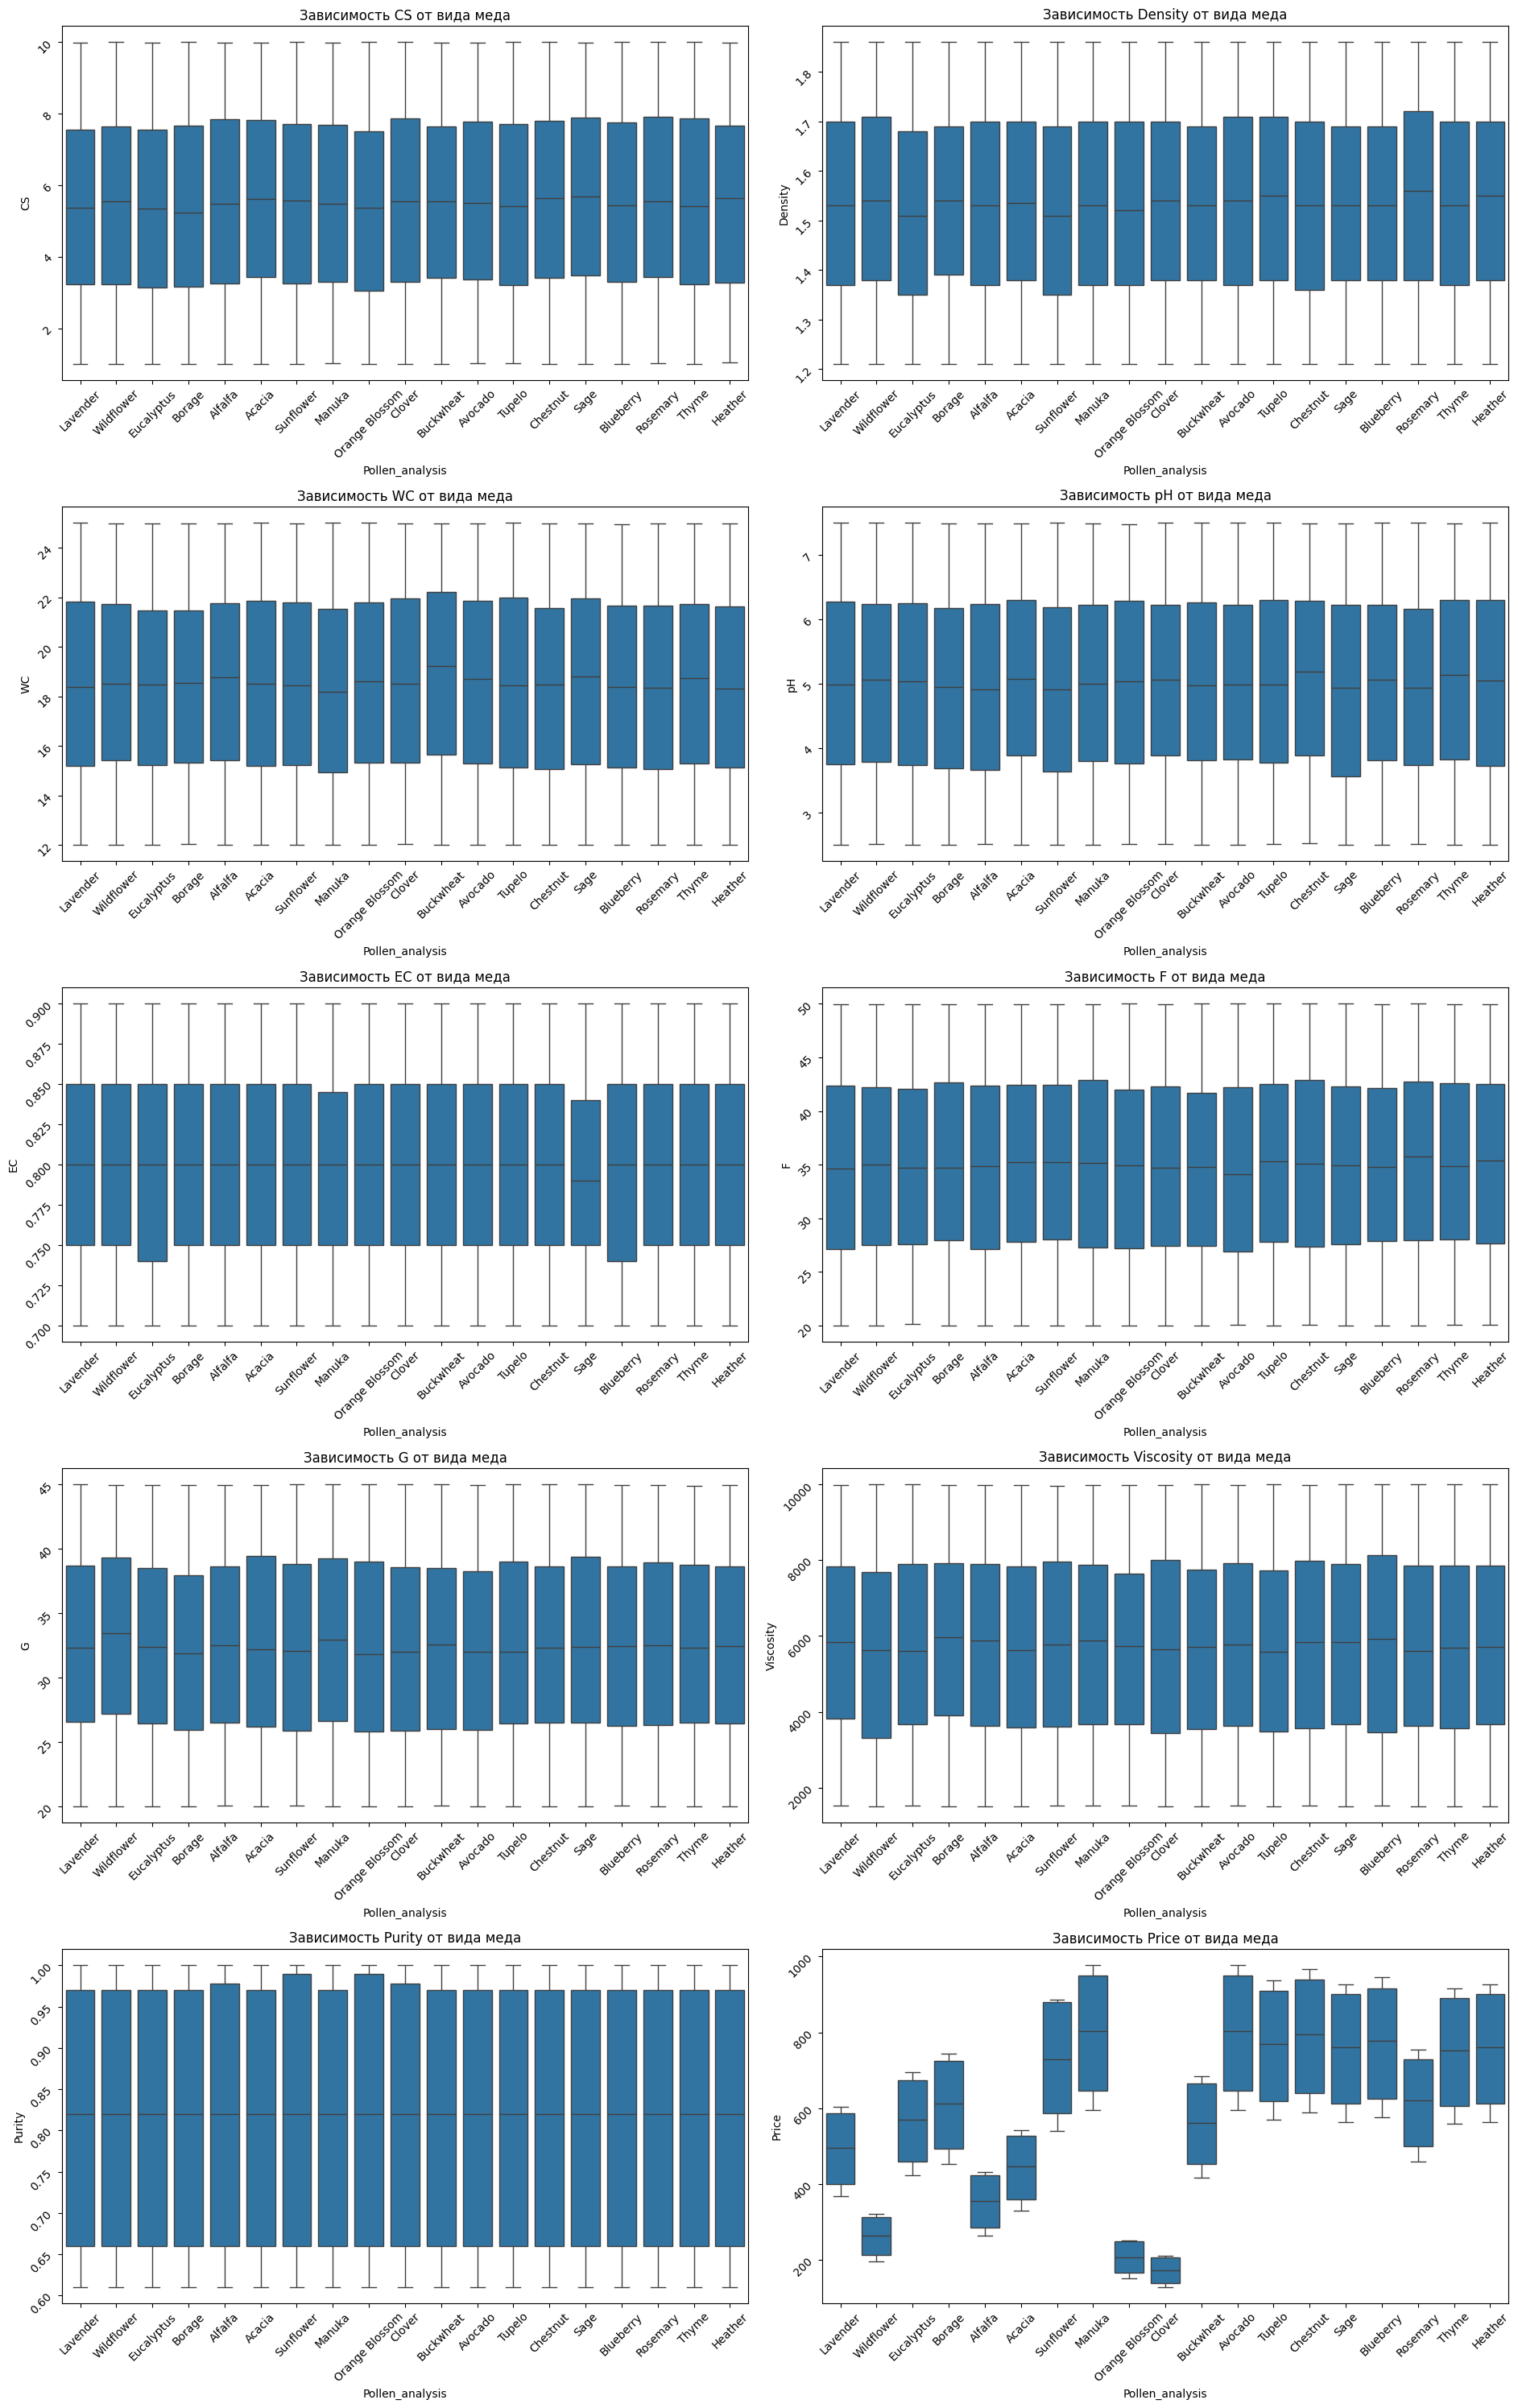

In [63]:
import seaborn as sns


fig, axes = plt.subplots(5, 2, figsize=(19, 30))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    sns.boxplot(x='Pollen_analysis', y=col, data=honey_df, ax=axes[i])
    axes[i].set_title(f'Зависимость {col} от вида меда')
    axes[i].tick_params(rotation=45)

plt.tight_layout()
plt.show()

Выбросов нет

Посмотрим корреляцию

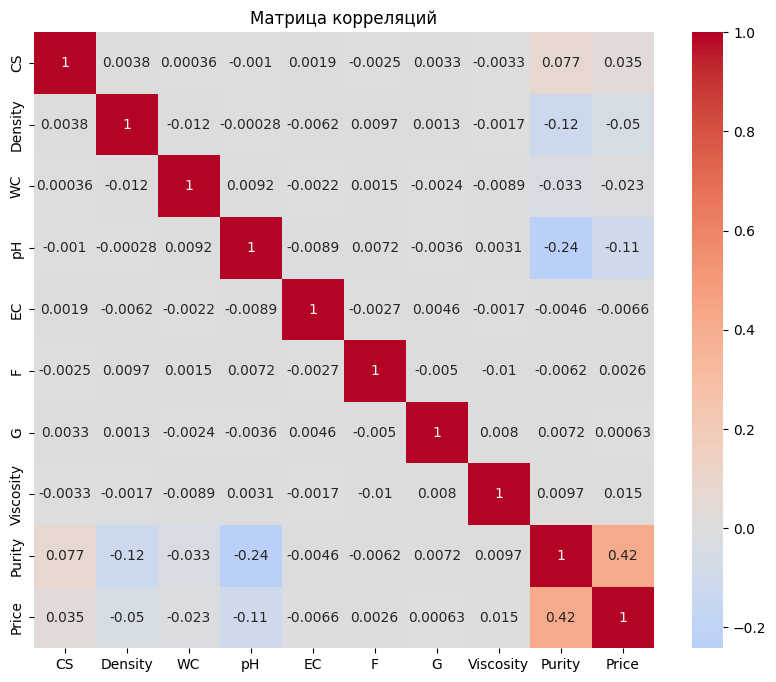

In [64]:
num_df = honey_df.select_dtypes(include=[np.number])
corr_matrix = num_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.show()

Начнем создавать новые features

Числовые фичи

In [65]:
def create_num_features(df):
    new_df = df.copy()
    new_df['CS*Density'] = df['CS'] * df['Density']
    new_df['pH*EC'] = df['pH'] * df['EC']
    new_df['F/G'] = df['F'] / (df['G'] + 1e-9)
    new_df['WC*pH'] = df['WC'] * df['pH']
    new_df['Density*Viscosity/WC'] = df['Density'] * df['Viscosity'] / (df['WC'] + 1e-9)
    new_df['G/F'] = df['G'] / (df['F'] + 1e-9)
    new_df['EC/pH'] = df['EC'] / (df['pH'] + 1e-9)
    new_df['F+G'] = df['F'] + df['G']
    new_df['F/G'] = df['F'] / df['G']
    new_df['F*G/WC'] = df['F'] * df['G'] / (df['WC'] + 1e-9)
    new_df['log_Viscosity'] = np.log1p(df['Viscosity'])
    new_df['log_Total_Sugars'] = np.log1p(df['F'] + df['G'])
    new_df['pH_deviation_ideal'] = abs(df['pH'] - 4.0)
    new_df['WC_deviation_ideal'] = abs(df['WC'] - 18.6)
    new_df['Density_deviation'] = abs(df['Density'] - 1.42)
    new_df['log1p(CS*Density*WC*pH*EC*F*G*Viscosity)'] = np.log1p(df['CS'] * df['Density'] * df['WC'] * df['pH'] * df['EC'] * df['F'] * df['G'] * df['Viscosity'])
    for col in ['CS', 'Density', 'WC', 'pH', 'EC', 'F', 'G', 'Viscosity']:
        new_df[f'{col}_to_mean'] = df[col] / df[col].mean()
        
    return new_df

Создадим категориальные фичи

In [66]:
def create_cat_features(df):
    new_df = df.copy()
    new_df['WC_Category'] = pd.cut(df['WC'], 
                           bins=[12, 17, 19, 25],
                           labels=['low', 'medium', 'high'])
    new_df['Density_Category'] = pd.cut(df['Density'],
                                bins=[1.21, 1.45, 1.65, 1.86],
                                labels=['light', 'medium', 'dense'])
    new_df['pH_Category'] = pd.cut(df['pH'],
                           bins=[2.5, 3.9, 5.1, 7.5],
                           labels=['acidic', 'normal', 'alkaline'])
    
    cat_cols = ['Pollen_analysis', 'WC_Category', 'Density_Category', 'pH_Category']

    for col in cat_cols:
        dummies = pd.get_dummies(new_df[col], prefix=col, dtype=int, drop_first=True)
        new_df = pd.concat([new_df, dummies], axis=1)
    new_df = new_df.drop(columns=cat_cols)
    
    return new_df
    

Применим функции выше и построим матрицу корреляций

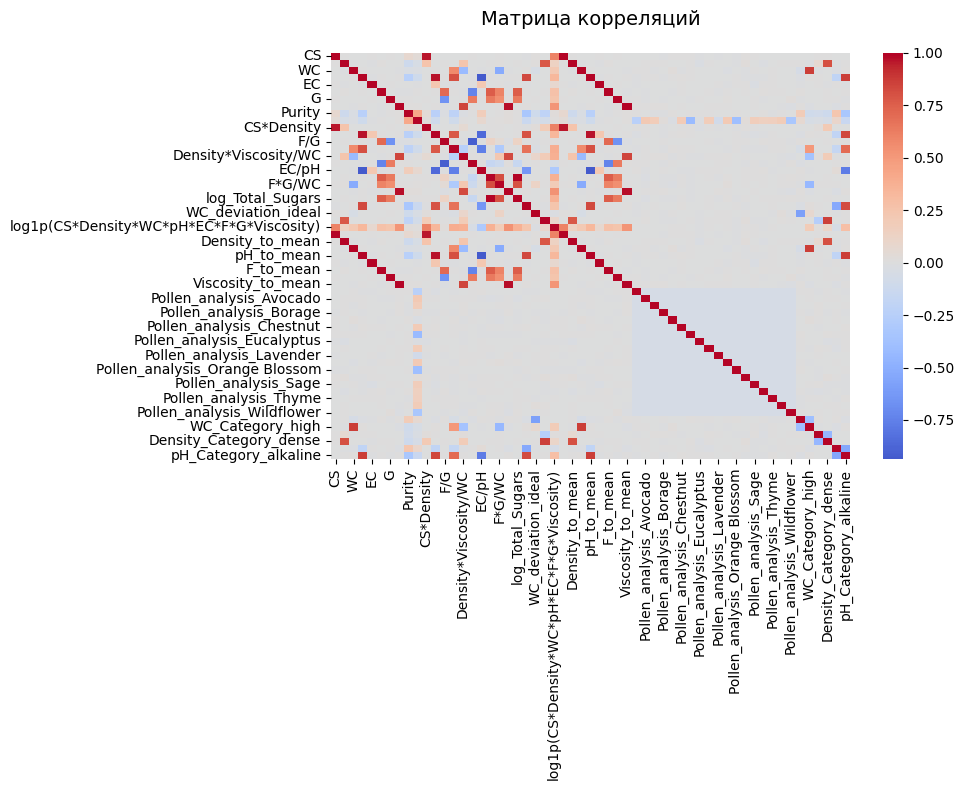

In [67]:
new_honey_df = create_num_features(honey_df)
new_honey_df = create_cat_features(new_honey_df)

corr_matrix = new_honey_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Матрица корреляций', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Посмотрим на результат после создания новых фич

In [68]:
from sklearn.discriminant_analysis import StandardScaler


honey_X = new_honey_df.drop(['Purity', 'Price'], axis=1)
honey_y = new_honey_df[['Purity', 'Price']]

scaler = StandardScaler()
honey_X = scaler.fit_transform(honey_X)

honey_X_train, honey_X_test, honey_y_train, honey_y_test = train_test_split(
    honey_X,
    honey_y,
    test_size=0.2,
    random_state=42
)

Кросс-валидация

In [70]:
scoring = {
    'neg_mse': 'neg_mean_squared_error',
    'neg_rmse': 'neg_root_mean_squared_error', 
    'neg_mae': 'neg_mean_absolute_error',   
    'r2' : 'r2',  
}

model = DecisionTreeRegressor()

results = {}

for model_name in ['Purity', 'Price']:
    cv_results = cross_validate(
        model,
        honey_X_train,
        honey_y_train[model_name],
        return_estimator=True,
        scoring=scoring,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    results[model_name] = cv_results
    results_df = pd.DataFrame(cv_results)
    print(f"\nРезультаты кросс-валидации для {model_name} модели:")
    print(results_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Результаты кросс-валидации для Purity модели:
   fit_time  score_time                estimator  test_neg_mse  test_neg_rmse  \
0  0.421603    0.002825  DecisionTreeRegressor()     -0.000941      -0.030679   
1  0.422060    0.002427  DecisionTreeRegressor()     -0.000688      -0.026236   
2  0.468829    0.002295  DecisionTreeRegressor()     -0.001004      -0.031679   
3  0.474014    0.002803  DecisionTreeRegressor()     -0.000920      -0.030328   
4  0.473144    0.002549  DecisionTreeRegressor()     -0.000819      -0.028614   

   test_neg_mae   test_r2  
0     -0.006297  0.951946  
1     -0.005122  0.964849  
2     -0.006553  0.948051  
3     -0.006288  0.951808  
4     -0.005888  0.957791  

Результаты кросс-валидации для Price модели:
   fit_time  score_time                estimator  test_neg_mse  test_neg_rmse  \
0  0.612743    0.002288  DecisionTreeRegressor()  -5197.547170     -72.094016   
1  0.607505    0.002314  DecisionTreeRegressor()  -3510.574003     -59.250097   
2  0.6237

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Замерим результат на тестовой выборке

In [71]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

preds = {}

for model_name in ['Purity', 'Price']:
    all_preds = []
    for model in results[model_name]['estimator']:
        pred = model.predict(honey_X_test)
        all_preds.append(pred)
    preds[model_name] = np.mean(all_preds, axis=0)
    
print("Test_score Purity:")
print('r2:', r2_score(honey_y_test['Purity'], preds['Purity']))
print('mse:', mean_squared_error(honey_y_test['Purity'], preds['Purity']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Purity'], preds['Purity'])))
print('mae:', mean_absolute_error(honey_y_test['Purity'], preds['Purity']))

print("\nTest_score Price:")
print('r2:', r2_score(honey_y_test['Price'], preds['Price']))
print('mse:', mean_squared_error(honey_y_test['Price'], preds['Price']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Price'], preds['Price'])))
print('mae:', mean_absolute_error(honey_y_test['Price'], preds['Price']))

Test_score Purity:
r2: 0.9729131494081332
mse: 0.0005339720000000001
rmse: 0.023107834169389396
mae: 0.005302000000000421

Test_score Price:
r2: 0.9567680467528239
mse: 2337.0367358679996
rmse: 48.34290781353558
mae: 19.929044000000054


| Метрика          | Purity           | Price            |
|------------------|------------------|------------------|
| r2               | 0.97291          | 0.95677          |
| mse              | 0.00053          | 2337.03674       |
| rmse             | 0.02311          | 48.34291         |
| mae              | 0.00530          | 19.92904         |

Попробуем еще улучшить, подобрав гиперпараметры

In [72]:
import optuna
from sklearn.model_selection import cross_val_score

def find_best_hyperparameters_cv(X, y, n_trials=10, cv=5, scoring='r2', n_jobs=-1):
    def objective(trial):
        max_depth = trial.suggest_int('max_depth', 3, 50)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        splitter = trial.suggest_categorical('splitter', ['best', 'random'])
        criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error'])
        
        model = DecisionTreeRegressor(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            splitter=splitter,
            criterion=criterion,
            random_state=42
        )
        
        
        return cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    return study.best_params


best_params = {
    'Purity': {'max_depth': 32, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': None, 'splitter': 'best', 'criterion': 'squared_error'},
    'Price': {'max_depth': 34, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': None, 'splitter': 'best', 'criterion': 'squared_error'}
}

best_models = {}

for model_name in ['Purity', 'Price']:
    if not best_params.get(model_name):
        best_params[model_name] = find_best_hyperparameters_cv(
                honey_X_train,
                honey_y_train[model_name],
                n_trials=10,
                cv=5,
                scoring='neg_mean_squared_error'
        )
        print(f"\n{model_name} model best params: {best_params[model_name]}\n")
    if not best_models.get(model_name):
        best_models[model_name] = DecisionTreeRegressor(**best_params[model_name])
        

Обучим модель с подобранными гиперпараметрами

In [73]:
scoring = {
    'neg_mse': 'neg_mean_squared_error',
    'neg_rmse': 'neg_root_mean_squared_error', 
    'neg_mae': 'neg_mean_absolute_error',   
    'r2' : 'r2',  
}

results = {}


for model_name, model in best_models.items():
    cv_results = cross_validate(
        model,
        honey_X_train,
        honey_y_train[model_name],
        return_estimator=True,
        scoring=scoring,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    results[model_name] = cv_results
    
    results_df = pd.DataFrame(cv_results)
    print(f"\nРезультаты кросс-валидации для {model_name} модели:")
    print(results_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Результаты кросс-валидации для Purity модели:
   fit_time  score_time                                          estimator  \
0  0.420757    0.002592  DecisionTreeRegressor(max_depth=32, min_sample...   
1  0.439884    0.002710  DecisionTreeRegressor(max_depth=32, min_sample...   
2  0.431836    0.002036  DecisionTreeRegressor(max_depth=32, min_sample...   
3  0.431648    0.001725  DecisionTreeRegressor(max_depth=32, min_sample...   
4  0.441291    0.001821  DecisionTreeRegressor(max_depth=32, min_sample...   

   test_neg_mse  test_neg_rmse  test_neg_mae   test_r2  
0     -0.000641      -0.025320     -0.005843  0.967270  
1     -0.000538      -0.023187     -0.005200  0.972545  
2     -0.000847      -0.029112     -0.006469  0.956128  
3     -0.000669      -0.025859     -0.006142  0.964966  
4     -0.000608      -0.024665     -0.005725  0.968637  

Результаты кросс-валидации для Price модели:
   fit_time  score_time                                          estimator  \
0  0.675473    0.0

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Замерим на тестовой выборке

In [74]:
preds = {}

for model_name in ['Purity', 'Price']:
    all_preds = []
    for model in results[model_name]['estimator']:
        pred = model.predict(honey_X_test)
        all_preds.append(pred)
    preds[model_name] = np.mean(all_preds, axis=0)
    
print("Test_score Purity:")
print('r2:', r2_score(honey_y_test['Purity'], preds['Purity']))
print('mse:', mean_squared_error(honey_y_test['Purity'], preds['Purity']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Purity'], preds['Purity'])))
print('mae:', mean_absolute_error(honey_y_test['Purity'], preds['Purity']))

print("\nTest_score Price:")
print('r2:', r2_score(honey_y_test['Price'], preds['Price']))
print('mse:', mean_squared_error(honey_y_test['Price'], preds['Price']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Price'], preds['Price'])))
print('mae:', mean_absolute_error(honey_y_test['Price'], preds['Price']))


Test_score Purity:
r2: 0.973590371629333
mse: 0.000520621695479655
rmse: 0.02281713600519695
mae: 0.00550494801587345

Test_score Price:
r2: 0.9615336285175882
mse: 2079.418497146295
rmse: 45.600641411566734
mae: 19.695795582761725


| Метрика          | Purity           | Price            |
|------------------|------------------|------------------|
| r2               | 0.97359          | 0.96153          |
| mse              | 0.00052          | 2079.41850       |
| rmse             | 0.02282          | 45.60064         |
| mae              | 0.00550          | 19.69580         |

Посмотрим переобучена ли модель

32
861


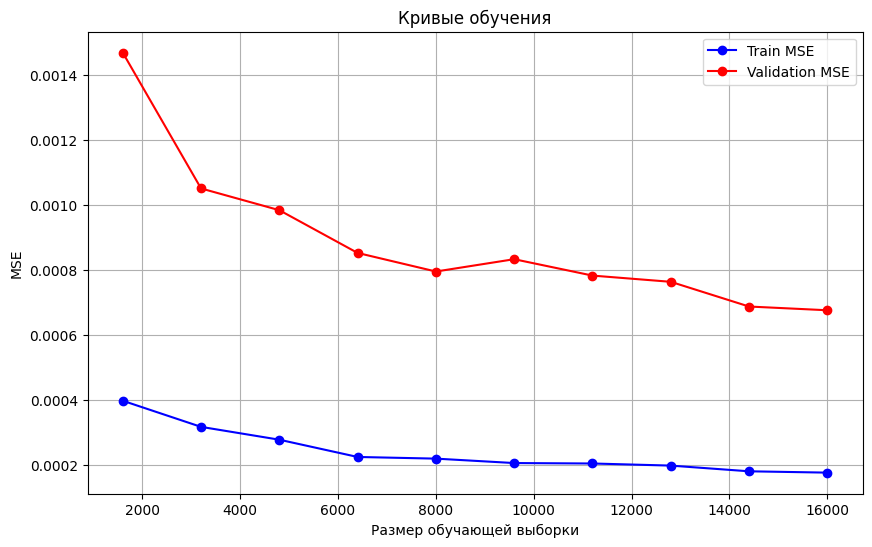

34
1546


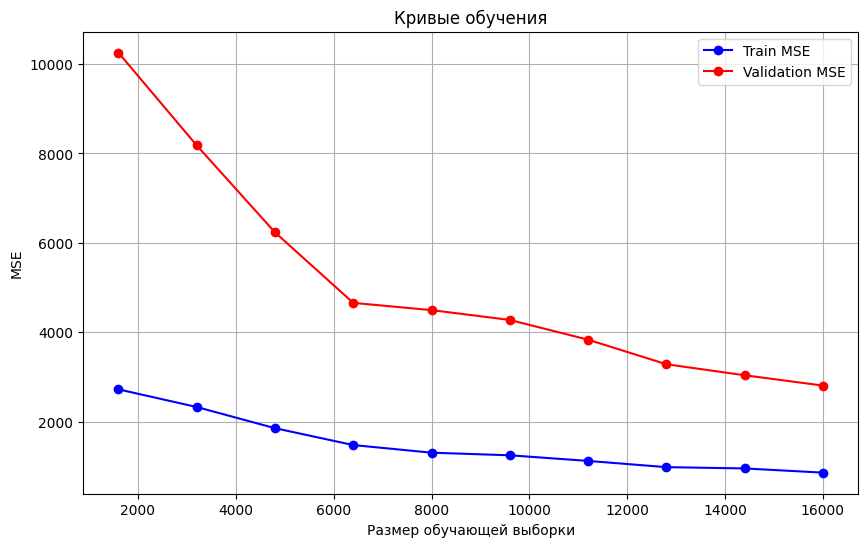

In [75]:
from sklearn.model_selection import learning_curve

print(results['Purity']['estimator'][0].get_depth())
print(results['Purity']['estimator'][0].get_n_leaves())

train_sizes, train_scores, test_scores = learning_curve(
    best_models['Purity'], honey_X, honey_y['Purity'], cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Train MSE')
plt.plot(train_sizes, test_scores_mean, 'o-', color='red', label='Validation MSE')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('MSE')
plt.title('Кривые обучения')
plt.legend()
plt.grid(True)
plt.show()

print(results['Price']['estimator'][0].get_depth())
print(results['Price']['estimator'][0].get_n_leaves())

train_sizes, train_scores, test_scores = learning_curve(
    best_models['Price'], honey_X, honey_y['Price'], cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Train MSE')
plt.plot(train_sizes, test_scores_mean, 'o-', color='red', label='Validation MSE')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('MSE')
plt.title('Кривые обучения')
plt.legend()
plt.grid(True)
plt.show()


Модель не переобучена

#### Выводы:

Генерация новых признаков и стандартизация данных улучшили качество моделей (Purity: r2=0.97291, Price: r2=0.95677). Последующая оптимизация гиперпараметров через Optuna дала дополнительный прирост (Purity: r2=0.97359, Price: r2=0.96153). Кривые обучения показывают отсутствие переобучения. Комплексная обработка данных и настройка гиперпараметров позволили повысить объясняющую способность моделей и снизить ошибки предсказания.

### 4.  Имплементация алгоритма машинного обучения 

4.1. Задача регрессии

In [78]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin

class LabDecisionTreeRegressor(BaseEstimator, RegressorMixin):
    
    class Node:
        def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
            self.feature_idx = feature_idx
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value
    
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1, 
                 max_features=None, splitter='best', criterion='squared_error', random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.splitter = splitter
        self.criterion = criterion
        self.random_state = random_state
        
        if random_state is not None:
            np.random.seed(random_state)
    
    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64).ravel()
        
        if X.ndim != 2:
            raise ValueError("X должен быть 2D массивом")
        if y.shape[0] != X.shape[0]:
            raise ValueError("X и y должны иметь одинаковое число строк")
            
        self.n_features_in_ = X.shape[1]
        self.root = self._build_tree(X, y, depth=0)
        return self

    def _get_feature_indices(self, n_features):
        if self.max_features is None:
            return np.arange(n_features)
        elif self.max_features == 'sqrt':
            n = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            n = max(1, int(np.log2(n_features)))
        elif isinstance(self.max_features, int):
            n = min(self.max_features, n_features)
        elif isinstance(self.max_features, float):
            n = max(1, int(self.max_features * n_features))
        else:
            n = n_features
        n = max(1, min(n, n_features))
        return np.random.choice(n_features, size=n, replace=False)

    def _build_tree(self, X, y, depth):
        n_samples = X.shape[0]
        
        if (depth >= self.max_depth or 
            n_samples < self.min_samples_split or 
            np.allclose(y, y[0])):
            return self.Node(value=self._leaf_value(y))
        
        feature_indices = self._get_feature_indices(X.shape[1])
        
        if self.splitter == 'best':
            if self.criterion == 'absolute_error':
                best_feature, best_threshold = self._find_best_split_mae(X, y, feature_indices)
            else:
                best_feature, best_threshold = self._find_best_split_mse(X, y, feature_indices)
        else:
            best_feature, best_threshold = self._find_random_split(X, y, feature_indices)
        
        if best_feature is None:
            return self.Node(value=self._leaf_value(y))
        
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
            return self.Node(value=self._leaf_value(y))
        
        left_node = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_node = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return self.Node(feature_idx=best_feature, threshold=best_threshold,
                         left=left_node, right=right_node)

    def _find_best_split_mse(self, X, y, feature_indices):
        best_improvement = -np.inf
        best_feature = None
        best_threshold = None
        n_total = y.size
        total_sum = y.sum()
        total_sum_sq = np.dot(y, y)
        parent_mse = (total_sum_sq - total_sum**2 / n_total) / n_total if n_total > 0 else 0

        for fid in feature_indices:
            feature = X[:, fid]
            if np.all(feature == feature[0]):
                continue

            sort_idx = np.argsort(feature)
            y_sorted = y[sort_idx]
            x_sorted = feature[sort_idx]

            valid_splits = np.where(x_sorted[1:] != x_sorted[:-1])[0] + 1
            if valid_splits.size == 0:
                continue

            valid_splits = valid_splits[
                (valid_splits >= self.min_samples_leaf) & 
                (n_total - valid_splits >= self.min_samples_leaf)
            ]
            if valid_splits.size == 0:
                continue

            left_n = valid_splits
            right_n = n_total - left_n

            cumsum = np.cumsum(y_sorted)
            left_sum = cumsum[valid_splits - 1]
            right_sum = total_sum - left_sum

            cumsum_sq = np.cumsum(y_sorted * y_sorted)
            left_sum_sq = cumsum_sq[valid_splits - 1]
            right_sum_sq = total_sum_sq - left_sum_sq

            left_mse = (left_sum_sq - left_sum**2 / left_n) / left_n
            right_mse = (right_sum_sq - right_sum**2 / right_n) / right_n

            weighted_mse = (left_n * left_mse + right_n * right_mse) / n_total
            improvement = parent_mse - weighted_mse

            best_local_idx = np.argmax(improvement)
            if improvement[best_local_idx] > best_improvement:
                best_improvement = improvement[best_local_idx]
                best_feature = fid
                i = valid_splits[best_local_idx]
                best_threshold = (x_sorted[i - 1] + x_sorted[i]) / 2.0

        return best_feature, best_threshold

    def _find_best_split_mae(self, X, y, feature_indices):
        best_improvement = -np.inf
        best_feature = None
        best_threshold = None
        n_total = y.size
        parent_mae = np.mean(np.abs(y - np.median(y)))

        for fid in feature_indices:
            feature = X[:, fid]
            if np.all(feature == feature[0]):
                continue

            sort_idx = np.argsort(feature)
            y_sorted = y[sort_idx]
            x_sorted = feature[sort_idx]

            valid_splits = np.where(x_sorted[1:] != x_sorted[:-1])[0] + 1
            valid_splits = valid_splits[
                (valid_splits >= self.min_samples_leaf) & 
                (n_total - valid_splits >= self.min_samples_leaf)
            ]
            if valid_splits.size == 0:
                continue

            for i in valid_splits:
                left_y = y_sorted[:i]
                right_y = y_sorted[i:]
                left_mae = np.mean(np.abs(left_y - np.median(left_y)))
                right_mae = np.mean(np.abs(right_y - np.median(right_y)))
                weighted_mae = (len(left_y) * left_mae + len(right_y) * right_mae) / n_total
                improvement = parent_mae - weighted_mae
                if improvement > best_improvement:
                    best_improvement = improvement
                    best_feature = fid
                    best_threshold = (x_sorted[i - 1] + x_sorted[i]) / 2.0

        return best_feature, best_threshold

    def _find_random_split(self, X, y, feature_indices):
        fid = np.random.choice(feature_indices)
        col = X[:, fid]
        if np.all(col == col[0]):
            return None, None
        threshold = np.random.uniform(col.min(), col.max())
        return fid, threshold

    def _leaf_value(self, y):
        if self.criterion == 'absolute_error':
            return np.median(y)
        return np.mean(y)

    def predict(self, X):
        X = np.asarray(X, dtype=np.float64)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        preds = np.empty(X.shape[0], dtype=np.float64)
        for i in range(X.shape[0]):
            node = self.root
            while node.value is None:
                if X[i, node.feature_idx] <= node.threshold:
                    node = node.left
                else:
                    node = node.right
            preds[i] = node.value
        return preds

1. Простой бейзлайн

In [79]:
honey_X = onehot_honey_df.drop(['Purity', 'Price'], axis=1)
honey_y = onehot_honey_df[['Purity', 'Price']]
honey_X_train, honey_X_test, honey_y_train, honey_y_test = train_test_split(
    honey_X,
    honey_y,
    test_size=0.2,
    random_state=42
)

Кросс-валидация

In [80]:
scoring = {
    'neg_mse': 'neg_mean_squared_error',
    'neg_rmse': 'neg_root_mean_squared_error', 
    'neg_mae': 'neg_mean_absolute_error',   
    'r2' : 'r2',  
}

model = LabDecisionTreeRegressor(max_depth=20)

results = {}

for model_name in ['Purity', 'Price']:
    cv_results = cross_validate(
        model,
        honey_X_train,
        honey_y_train[model_name],
        return_estimator=True,
        scoring=scoring,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    results[model_name] = cv_results
    results_df = pd.DataFrame(cv_results)
    print(f"\nРезультаты кросс-валидации для {model_name} модели:")
    print(results_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Результаты кросс-валидации для Purity модели:
   fit_time  score_time                               estimator  test_neg_mse  \
0  1.423734    0.008589  LabDecisionTreeRegressor(max_depth=20)     -0.000880   
1  1.327061    0.011834  LabDecisionTreeRegressor(max_depth=20)     -0.000902   
2  1.400307    0.008697  LabDecisionTreeRegressor(max_depth=20)     -0.001030   
3  1.379640    0.009948  LabDecisionTreeRegressor(max_depth=20)     -0.000926   
4  1.391333    0.009017  LabDecisionTreeRegressor(max_depth=20)     -0.000786   

   test_neg_rmse  test_neg_mae   test_r2  
0      -0.029662     -0.006569  0.955081  
1      -0.030039     -0.006803  0.953920  
2      -0.032097     -0.006925  0.946671  
3      -0.030425     -0.006619  0.951500  
4      -0.028042     -0.006038  0.959460  

Результаты кросс-валидации для Price модели:
   fit_time  score_time                               estimator  test_neg_mse  \
0  1.850486    0.012421  LabDecisionTreeRegressor(max_depth=20)  -6775.893932   


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Посмотрим результат на тестовой выборке, усреднив результат всех моделей

In [81]:
preds = {}

for model_name in ['Purity', 'Price']:
    all_preds = []
    for model in results[model_name]['estimator']:
        pred = model.predict(honey_X_test)
        all_preds.append(pred)
    preds[model_name] = np.mean(all_preds, axis=0)
    
print("Test_score Purity:")
print('r2:', r2_score(honey_y_test['Purity'], preds['Purity']))
print('mse:', mean_squared_error(honey_y_test['Purity'], preds['Purity']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Purity'], preds['Purity'])))
print('mae:', mean_absolute_error(honey_y_test['Purity'], preds['Purity']))

print("\nTest_score Price:")
print('r2:', r2_score(honey_y_test['Price'], preds['Price']))
print('mse:', mean_squared_error(honey_y_test['Price'], preds['Price']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Price'], preds['Price'])))
print('mae:', mean_absolute_error(honey_y_test['Price'], preds['Price']))

Test_score Purity:
r2: 0.9722373629931436
mse: 0.0005472939999999999
rmse: 0.023394315548867846
mae: 0.006002000000000041

Test_score Price:
r2: 0.9118342159214707
mse: 4766.073720057699
rmse: 69.03675629733554
mae: 37.57680624892266


| Метрика          | Purity           | Price            |
|------------------|------------------|------------------|
| r2               | 0.97224          | 0.91183          |
| mse              | 0.00055          | 4766.07372       |
| rmse             | 0.02339          | 69.03676         |
| mae              | 0.00600          | 37.57681         |

#### Вывод:

Реализованный класс LabDecisionTreeRegressor корректно работает для задач регрессии. На простом бейзлайне результаты несколько хуже sklearn (Price: r2=0.91183 против 0.94153). Реализация поддерживает основные критерии и стратегии разбиения.

Улучшим бейзлайн

In [82]:
new_honey_df = create_num_features(honey_df)
new_honey_df = create_cat_features(new_honey_df)

honey_X = new_honey_df.drop(['Purity', 'Price'], axis=1)
honey_y = new_honey_df[['Purity', 'Price']]

scaler = StandardScaler()
honey_X = scaler.fit_transform(honey_X)

honey_X_train, honey_X_test, honey_y_train, honey_y_test = train_test_split(
    honey_X,
    honey_y,
    test_size=0.2,
    random_state=42
)

Посмотрим, что получилось после создания новых фич и применения StandardScaler

In [83]:
scoring = {
    'neg_mse': 'neg_mean_squared_error',
    'neg_rmse': 'neg_root_mean_squared_error', 
    'neg_mae': 'neg_mean_absolute_error',   
    'r2' : 'r2',  
}

model = LabDecisionTreeRegressor(max_depth=20)

results = {}

for model_name in ['Purity', 'Price']:
    cv_results = cross_validate(
        model,
        honey_X_train,
        honey_y_train[model_name],
        return_estimator=True,
        scoring=scoring,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    results[model_name] = cv_results
    results_df = pd.DataFrame(cv_results)
    print(f"\nРезультаты кросс-валидации для {model_name} модели:")
    print(results_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Результаты кросс-валидации для Purity модели:
   fit_time  score_time                               estimator  test_neg_mse  \
0  2.184093    0.007994  LabDecisionTreeRegressor(max_depth=20)     -0.000972   
1  2.179382    0.006194  LabDecisionTreeRegressor(max_depth=20)     -0.000754   
2  2.204345    0.006796  LabDecisionTreeRegressor(max_depth=20)     -0.001000   
3  2.193640    0.006227  LabDecisionTreeRegressor(max_depth=20)     -0.000801   
4  2.211616    0.005965  LabDecisionTreeRegressor(max_depth=20)     -0.000815   

   test_neg_rmse  test_neg_mae   test_r2  
0      -0.031179     -0.006297  0.950367  
1      -0.027455     -0.005300  0.961509  
2      -0.031620     -0.006300  0.948243  
3      -0.028300     -0.005619  0.958040  
4      -0.028555     -0.005584  0.957963  

Результаты кросс-валидации для Price модели:
   fit_time  score_time                               estimator  test_neg_mse  \
0  4.113591    0.009114  LabDecisionTreeRegressor(max_depth=20)  -5993.139418   


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Посмотрим результат на тестовой выборке, усреднив результат всех моделей

In [84]:
preds = {}

for model_name in ['Purity', 'Price']:
    all_preds = []
    for model in results[model_name]['estimator']:
        pred = model.predict(honey_X_test)
        all_preds.append(pred)
    preds[model_name] = np.mean(all_preds, axis=0)
    
print("Test_score Purity:")
print('r2:', r2_score(honey_y_test['Purity'], preds['Purity']))
print('mse:', mean_squared_error(honey_y_test['Purity'], preds['Purity']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Purity'], preds['Purity'])))
print('mae:', mean_absolute_error(honey_y_test['Purity'], preds['Purity']))

print("\nTest_score Price:")
print('r2:', r2_score(honey_y_test['Price'], preds['Price']))
print('mse:', mean_squared_error(honey_y_test['Price'], preds['Price']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Price'], preds['Price'])))
print('mae:', mean_absolute_error(honey_y_test['Price'], preds['Price']))

Test_score Purity:
r2: 0.9728606468605041
mse: 0.000535007
rmse: 0.0231302183301412
mae: 0.00530150000000006

Test_score Price:
r2: 0.9152639891236711
mse: 4580.666738249365
rmse: 67.68062306339507
mae: 33.46598878993647


| Метрика          | Purity           | Price            |
|------------------|------------------|------------------|
| r2               | 0.97286          | 0.91526          |
| mse              | 0.00054          | 4580.66674       |
| rmse             | 0.02313          | 67.68062         |
| mae              | 0.00530          | 33.46599         |

Попробуем еще улучшить, подобрав гиперпараметры

In [85]:

def find_best_hyperparameters_cv(X, y, n_trials=10, cv=5, scoring='r2', n_jobs=-1):
    def objective(trial):
        max_depth = trial.suggest_int('max_depth', 3, 50)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        splitter = trial.suggest_categorical('splitter', ['best', 'random'])
        criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error'])
        
        model = LabDecisionTreeRegressor(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            splitter=splitter,
            criterion=criterion,
            random_state=42
        )
        
        
        return cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    return study.best_params

best_params = {
    'Purity': {'max_depth': 32, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': None, 'splitter': 'best', 'criterion': 'squared_error'},
    'Price': {'max_depth': 34, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': None, 'splitter': 'best', 'criterion': 'squared_error'}
}


best_models = {}

for model_name in ['Purity', 'Price']:
    if not best_params.get(model_name):
        best_params[model_name] = find_best_hyperparameters_cv(
                honey_X_train,
                honey_y_train[model_name],
                n_trials=10,
                cv=5,
                scoring='neg_mean_squared_error'
        )
        print(f"\n{model_name} model best params: {best_params[model_name]}\n")
    if not best_models.get(model_name):
        best_models[model_name] = LabDecisionTreeRegressor(**best_params[model_name])
        

Обучим модель с подобранными гиперпараметрами

In [86]:
scoring = {
    'neg_mse': 'neg_mean_squared_error',
    'neg_rmse': 'neg_root_mean_squared_error', 
    'neg_mae': 'neg_mean_absolute_error',   
    'r2' : 'r2',  
}

results = {}


for model_name, model in best_models.items():
    cv_results = cross_validate(
        model,
        honey_X_train,
        honey_y_train[model_name],
        return_estimator=True,
        scoring=scoring,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    results[model_name] = cv_results
    
    results_df = pd.DataFrame(cv_results)
    print(f"\nРезультаты кросс-валидации для {model_name} модели:")
    print(results_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Результаты кросс-валидации для Purity модели:
   fit_time  score_time                                          estimator  \
0  1.609777    0.008602  LabDecisionTreeRegressor(max_depth=32, min_sam...   
1  1.645956    0.005864  LabDecisionTreeRegressor(max_depth=32, min_sam...   
2  1.682058    0.006006  LabDecisionTreeRegressor(max_depth=32, min_sam...   
3  1.601074    0.010478  LabDecisionTreeRegressor(max_depth=32, min_sam...   
4  1.628191    0.006475  LabDecisionTreeRegressor(max_depth=32, min_sam...   

   test_neg_mse  test_neg_rmse  test_neg_mae   test_r2  
0     -0.000725      -0.026926     -0.005728  0.962985  
1     -0.000596      -0.024405     -0.005278  0.969585  
2     -0.000822      -0.028668     -0.006034  0.957456  
3     -0.000632      -0.025136     -0.005678  0.966897  
4     -0.000632      -0.025139     -0.005604  0.967420  

Результаты кросс-валидации для Price модели:
   fit_time  score_time                                          estimator  \
0  2.782508    0.0

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Замерим на тестовой выборке

In [87]:
preds = {}

for model_name in ['Purity', 'Price']:
    all_preds = []
    for model in results[model_name]['estimator']:
        pred = model.predict(honey_X_test)
        all_preds.append(pred)
    preds[model_name] = np.mean(all_preds, axis=0)
    
print("Test_score Purity:")
print('r2:', r2_score(honey_y_test['Purity'], preds['Purity']))
print('mse:', mean_squared_error(honey_y_test['Purity'], preds['Purity']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Purity'], preds['Purity'])))
print('mae:', mean_absolute_error(honey_y_test['Purity'], preds['Purity']))

print("\nTest_score Price:")
print('r2:', r2_score(honey_y_test['Price'], preds['Price']))
print('mse:', mean_squared_error(honey_y_test['Price'], preds['Price']))
print('rmse:', np.sqrt(mean_squared_error(honey_y_test['Price'], preds['Price'])))
print('mae:', mean_absolute_error(honey_y_test['Price'], preds['Price']))

Test_score Purity:
r2: 0.9744812240611875
mse: 0.0005030600283109725
rmse: 0.022428999717128997
mae: 0.0053402567460318

Test_score Price:
r2: 0.9626713416929197
mse: 2017.9158981212443
rmse: 44.92121879603496
mae: 18.82721737178296


| Метрика          | Purity           | Price            |
|------------------|------------------|------------------|
| r2               | 0.97448          | 0.96267          |
| mse              | 0.00050          | 2017.91590       |
| rmse             | 0.02243          | 44.92122         |
| mae              | 0.00534          | 18.82722         |

Посмотрим переобучена ли модель

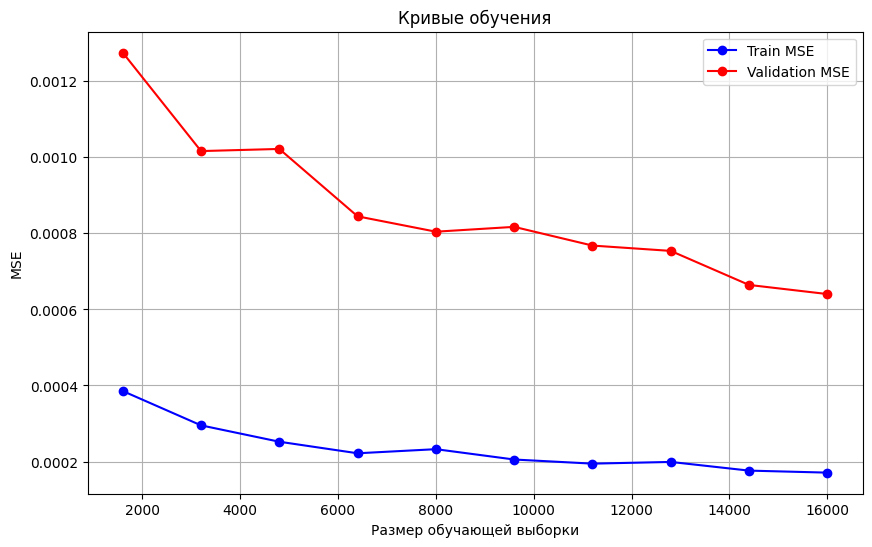

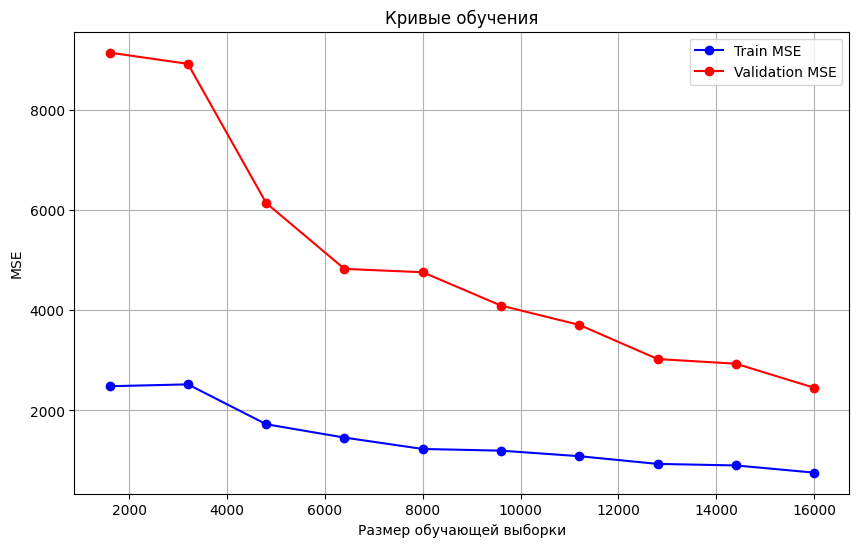

In [88]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_models['Purity'], honey_X, honey_y['Purity'], cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Train MSE')
plt.plot(train_sizes, test_scores_mean, 'o-', color='red', label='Validation MSE')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('MSE')
plt.title('Кривые обучения')
plt.legend()
plt.grid(True)
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    best_models['Price'], honey_X, honey_y['Price'], cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Train MSE')
plt.plot(train_sizes, test_scores_mean, 'o-', color='red', label='Validation MSE')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('MSE')
plt.title('Кривые обучения')
plt.legend()
plt.grid(True)
plt.show()


#### Вывод:

Реализованный класс LabDecisionTreeRegressor корректно работает для задач регрессии. После улучшений качество сравнялось (Price: r2=0.96267 против 0.96153 у sklearn)